In [1]:
%matplotlib inline 
#to include graphs next to the code
#useful libraries
import numpy as np #linear algebra
import math
import pandas as pd #data processing
import matplotlib.pyplot as plt #plotting
import seaborn as sns #visualization


file='withoutcolumns.csv'
df = pd.read_csv(file)
print(df.describe()) #statistics 

         Unnamed: 0          index  ...  totalwalkingdistance  totalwaitingtime
count  85153.000000   85153.000000  ...          85153.000000      85153.000000
mean   42576.000000   49644.320294  ...              0.124514          4.723705
std    24581.698073   36107.436508  ...              0.195947         14.432200
min        0.000000       0.000000  ...              0.000000          0.000000
25%    21288.000000   21288.000000  ...              0.000000          0.000000
50%    42576.000000   42576.000000  ...              0.000000          0.000000
75%    63864.000000   66045.000000  ...              0.216000          1.330000
max    85152.000000  138243.000000  ...              0.965000        212.860000

[8 rows x 7 columns]


In [2]:
#redundant column via reading
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)

In [3]:
df.rename({'totaltraveltimeinsec': 'totaltraveltimeinhours'}, axis=1, inplace=True)
df

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,objective,finiteautomaton,consideredpreferences,finalsolutionusedlabels,sourcename,targetname
0,3.93,0.86,0,0.000,0.00,price,all,"[travelTime, price]",[flixbus],Essen,Gelsenkirchen
1,1.33,2.17,0,0.000,0.00,price,all,"[travelTime, price]",[db_fv],Essen,Gelsenkirchen
2,1.33,2.17,0,0.000,0.00,travelTime,all,"[travelTime, price]",[db_fv],Essen,Gelsenkirchen
3,3.93,0.86,0,0.000,0.00,travelTime,all,"[travelTime, price]",[flixbus],Essen,Gelsenkirchen
4,3.93,0.86,0,0.000,0.00,price,ptOnly,"[travelTime, price]",[flixbus],Essen,Gelsenkirchen
...,...,...,...,...,...,...,...,...,...,...,...
85148,51.67,91.20,1,0.000,6.83,waitingTime,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],Würzburg,Oberhausen
85149,61.33,86.04,1,0.000,15.33,waitingTime,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],Würzburg,Oberhausen
85150,45.39,22.47,1,0.177,2.54,numberofChanges,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]",Würzburg,Oberhausen
85151,45.39,22.47,1,0.177,2.54,walkingDistance,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]",Würzburg,Oberhausen


In [4]:
#we do not have missing values, because we use the previous approach with 0s for them for the trial clustering round
df.isna().sum()

totaltraveltimeinhours     0
totalprice                 0
totalnumberofchanges       0
totalwalkingdistance       0
totalwaitingtime           0
objective                  0
finiteautomaton            0
consideredpreferences      0
finalsolutionusedlabels    0
sourcename                 0
targetname                 0
dtype: int64

In [5]:
#make a copy of data to perform Hopkins Statistics to decide on whether our data could be clustered or not
#involved numerical columns
#will repeat it after encoding of categorical for DBscan and check what was the coeficient
dfhopkins=df.copy()

In [6]:
#drop categorical columns for the statistics
dfhopkins.drop(dfhopkins.columns[[5,6,7,8,9,10]], axis = 1, inplace = True)

In [7]:
#check the newest dataframe- only numerical are inside
dfhopkins

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime
0,3.93,0.86,0,0.000,0.00
1,1.33,2.17,0,0.000,0.00
2,1.33,2.17,0,0.000,0.00
3,3.93,0.86,0,0.000,0.00
4,3.93,0.86,0,0.000,0.00
...,...,...,...,...,...
85148,51.67,91.20,1,0.000,6.83
85149,61.33,86.04,1,0.000,15.33
85150,45.39,22.47,1,0.177,2.54
85151,45.39,22.47,1,0.177,2.54


In [8]:
import sklearn 
from sklearn.preprocessing import StandardScaler
# we need to standardize values through scaler
scaler = StandardScaler()
# fit_transform
dfnew_scaled = scaler.fit_transform(dfhopkins)

In [9]:
#check the data
dfnew_scaled

array([[-1.31591577, -1.36344196, -1.06797343, -0.63545072, -0.32730509],
       [-1.40411342, -1.32727631, -1.06797343, -0.63545072, -0.32730509],
       [-1.40411342, -1.32727631, -1.06797343, -0.63545072, -0.32730509],
       ...,
       [ 0.09049763, -0.76684683,  0.11504693,  0.26786201, -0.15130871],
       [ 0.09049763, -0.76684683,  0.11504693,  0.26786201, -0.15130871],
       [-0.22226482,  1.62257052,  0.11504693, -0.63545072, -0.28088085]])

In [10]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
#Generate a simulated data set (random D) drawn from a random uniform distribution with n points (q1,q2,…, qn) and the same variation as the original real data set D.
    rand_X = sample(range(0, n, 1), m)
 #Compute the distance, xi, from each real point to each nearest neighbour: For each point, pi ∈ D, find it’s nearest neighbour pj; 
 #then compute the distance between pi and pj and denote it as xi=dist(pi,pj)
    ujd = []
#Compute the distance, yi from each artificial point to the nearest real data point: For each point qi ∈ random D, find it’s nearest neighbour qj in D; then compute the distance between qi and qj and denote it yi=dist(qi,qj)
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
#Calculate the Hopkins statistic (H) as the mean nearest neighbour distance in the random data set divided by the sum of the mean nearest neighbour distances in the real and across the simulated data set.
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [11]:
#convert “dfscaled” to pandas DataFrame & define previouscolumn names 
dfnew_scaled = pd.DataFrame(dfnew_scaled)
dfnew_scaled.columns =['totaltraveltimeinhours','totalprice','totalnumberofchanges','totalwalkingdistance', 'totalwaitingtime']

In [12]:
#apply Hopkins function to the dataset
#the clusters should be meaningful considering the numerical columns
#function hopkins compare scatter spread of data points from our dataset to random scatter data which contains no cluster tendency or properties,using NearestNeighbors
#the test tells us how much percentage different is our data from random scatter data
# can do Hopkins test before scaling or after the scaling as the scale of x-axis & y-axis changes it does not affect the spread of points

hopkins(dfnew_scaled)

#can conduct the Hopkins Statistic test iteratively, using 0.5 as the threshold to reject the alternative hypothesis.
#if H < 0.5, then it is unlikely that D has statistically significant clusters.
#if the value of Hopkins statistic is close to 1, then we can reject the null hypothesis and conclude that the dataset D is significantly a clusterable data.
#our values is extremely close to 1

0.9995403745466414

In [13]:

#define what columns we need to drop for the clustering
# goal is to cluster the group of trips and see maybe we can detect some new patterns in the data based on clusters
#was decided to drop column objective-super low degree of association-0,05.. doesnt have any meaningfull information for clustering
#we have completely identical rows with all numerical/categorical variables (having the same labesls) with difference only in objective=> it doesnt change anything
#it also repeats somehow the combinations inside the 'considered preferences" column, whoch we will use for clustering

#drop sourcename and targetname for the algorithm- we would need to consider the groups of trips in Germany in general


df.drop(df.columns[[5, 9, 10]], axis = 1, inplace = True)

In [14]:
#the duplicated were removed
df.drop_duplicates(keep='last', inplace=True)

In [15]:
#from 85153 to 30199 thousands of rows (mainly because of reducing the objective column)
df

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels
2,1.33,2.17,0,0.000,0.00,all,"[travelTime, price]",[db_fv]
3,3.93,0.86,0,0.000,0.00,all,"[travelTime, price]",[flixbus]
6,1.33,2.89,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv]
7,1.33,2.17,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv]
8,3.93,0.86,0,0.000,0.00,ptOnly,"[travelTime, price]",[flixbus]
...,...,...,...,...,...,...,...,...
85147,36.33,106.46,1,0.000,4.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv]
85148,51.67,91.20,1,0.000,6.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv]
85149,61.33,86.04,1,0.000,15.33,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv]
85151,45.39,22.47,1,0.177,2.54,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]"


In [16]:
#for k.prototypes we need float as the input
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30199 entries, 2 to 85152
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   totaltraveltimeinhours   30199 non-null  float64
 1   totalprice               30199 non-null  float64
 2   totalnumberofchanges     30199 non-null  int64  
 3   totalwalkingdistance     30199 non-null  float64
 4   totalwaitingtime         30199 non-null  float64
 5   finiteautomaton          30199 non-null  object 
 6   consideredpreferences    30199 non-null  object 
 7   finalsolutionusedlabels  30199 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 2.1+ MB


In [24]:
#our numerical columns are within the different rnge we need to scale them for clustering
clscaled=df.copy()

In [25]:
#standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
scaled_new = StandardScaler().fit_transform(clscaled[['totaltraveltimeinhours', 'totalprice','totalnumberofchanges','totalwalkingdistance','totalwaitingtime']])
clscaled[['totaltraveltimeinhours', 'totalprice','totalnumberofchanges','totalwalkingdistance','totalwaitingtime']] = scaled_new

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime
2,True,True,True,True,True
3,True,True,True,True,True
6,True,True,True,True,True
7,True,True,True,True,True
8,True,True,True,True,True
...,...,...,...,...,...
85147,True,True,True,True,True
85148,True,True,True,True,True
85149,True,True,True,True,True
85151,True,True,True,True,True


In [26]:
#check if everything got scaled
clscaled

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels
2,1.33,2.17,0,0.000,0.00,all,"[travelTime, price]",[db_fv]
3,3.93,0.86,0,0.000,0.00,all,"[travelTime, price]",[flixbus]
6,1.33,2.89,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv]
7,1.33,2.17,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv]
8,3.93,0.86,0,0.000,0.00,ptOnly,"[travelTime, price]",[flixbus]
...,...,...,...,...,...,...,...,...
85147,36.33,106.46,1,0.000,4.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv]
85148,51.67,91.20,1,0.000,6.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv]
85149,61.33,86.04,1,0.000,15.33,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv]
85151,45.39,22.47,1,0.177,2.54,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]"


In [27]:
# Get the position of categorical columns
#use preference, automation and transport
catColumnsPos = [df.columns.get_loc(col) for col in list(clscaled.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(clscaled.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['finiteautomaton', 'consideredpreferences', 'finalsolutionusedlabels']
Categorical columns position  : [5, 6, 7]


In [28]:
# Convert dataframe to matrix- we need it for kprototypes input as well as floats
dfmatrix = clscaled.to_numpy()
dfmatrix

array([[1.33, 2.17, 0, ..., 'all', '[travelTime, price]', '[db_fv]'],
       [3.93, 0.86, 0, ..., 'all', '[travelTime, price]', '[flixbus]'],
       [1.33, 2.89, 0, ..., 'ptOnly', '[travelTime, price]', '[db_fv]'],
       ...,
       [61.33, 86.04, 1, ..., 'ptOnly',
        '[travelTime, price, numberofChanges, walkingDistance, waitingTime]',
        '[db_fv]'],
       [45.39, 22.47, 1, ..., 'noFlights',
        '[travelTime, price, numberofChanges, walkingDistance, waitingTime]',
        '[blablacar, db_fv]'],
       [36.17, 109.02, 1, ..., 'noFlights',
        '[travelTime, price, numberofChanges, walkingDistance, waitingTime]',
        '[db_fv]']], dtype=object)

In [29]:
#install the library
!pip install kmodes

In [149]:
#to check how many clusters?
from tqdm import tqdm
#running time is 1+hour
costs = []
n_clusters = []
clusters_assigned = []

cat_cols = [5,6,7]

for i in tqdm(range(2, 10)):
    try:
        kproto = KPrototypes(n_clusters=i, init='Huang', verbose=2)
        clusters = kproto.fit_predict(dfmatrix, categorical=cat_cols)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")

  0%|          | 0/8 [00:00<?, ?it/s]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 979, ncost: 48693534.75471241
Run: 1, iteration: 2/100, moves: 119, ncost: 48691288.63785383
Run: 1, iteration: 3/100, moves: 4, ncost: 48691287.0462213
Run: 1, iteration: 4/100, moves: 0, ncost: 48691287.0462213
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 1983, ncost: 57943859.98468819
Run: 2, iteration: 2/100, moves: 245, ncost: 57935426.64278208
Run: 2, iteration: 3/100, moves: 38, ncost: 57934920.9418913
Run: 2, iteration: 4/100, moves: 39, ncost: 57934625.54845152
Run: 2, iteration: 5/100, moves: 19, ncost: 57934521.50332836
Run: 2, iteration: 6/100, moves: 43, ncost: 57933983.11398233
Run: 2, iteration: 7/100, moves: 17, ncost: 57933870.2217421
Run: 2, iteration: 8/100, moves: 4, ncost: 57933866.48596886
Run: 2, iteration: 9/100, moves: 0, ncost: 57933866.48596886
Init: initializing centroids
Init: in

 12%|█▎        | 1/8 [04:42<32:57, 282.56s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 7802, ncost: 31284700.613989938
Run: 1, iteration: 2/100, moves: 2505, ncost: 30557859.434206888
Run: 1, iteration: 3/100, moves: 631, ncost: 30510827.99378996
Run: 1, iteration: 4/100, moves: 208, ncost: 30503125.981981907
Run: 1, iteration: 5/100, moves: 60, ncost: 30502177.136031963
Run: 1, iteration: 6/100, moves: 58, ncost: 30501259.447507825
Run: 1, iteration: 7/100, moves: 20, ncost: 30501165.542655297
Run: 1, iteration: 8/100, moves: 0, ncost: 30501165.542655297
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 5155, ncost: 44164975.47008161
Run: 2, iteration: 2/100, moves: 1790, ncost: 43876257.73621639
Run: 2, iteration: 3/100, moves: 716, ncost: 43820342.26313393
Run: 2, iteration: 4/100, moves: 325, ncost: 43807748.32100405
Run: 2, iteration: 5/100, moves: 226, ncost: 43801319.97513838
Run: 2, iterati

 25%|██▌       | 2/8 [10:50<33:16, 332.74s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 10281, ncost: 26161481.224751893
Run: 1, iteration: 2/100, moves: 1238, ncost: 26077121.97645358
Run: 1, iteration: 3/100, moves: 521, ncost: 26054121.512575995
Run: 1, iteration: 4/100, moves: 381, ncost: 26042269.012354635
Run: 1, iteration: 5/100, moves: 172, ncost: 26037425.230537992
Run: 1, iteration: 6/100, moves: 338, ncost: 26024988.387563966
Run: 1, iteration: 7/100, moves: 270, ncost: 26018240.13534625
Run: 1, iteration: 8/100, moves: 143, ncost: 26016202.22277624
Run: 1, iteration: 9/100, moves: 27, ncost: 26016140.286496673
Run: 1, iteration: 10/100, moves: 0, ncost: 26016140.286496673
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 5724, ncost: 26689031.32193289
Run: 2, iteration: 2/100, moves: 2465, ncost: 26191121.609904513
Run: 2, iteration: 3/100, moves: 1180, ncost: 26093265.61097025
Run: 2, i

 38%|███▊      | 3/8 [18:56<33:33, 402.61s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4508, ncost: 21074459.97234159
Run: 1, iteration: 2/100, moves: 3651, ncost: 20187626.783751685
Run: 1, iteration: 3/100, moves: 2055, ncost: 19905554.96502769
Run: 1, iteration: 4/100, moves: 839, ncost: 19843362.3916674
Run: 1, iteration: 5/100, moves: 462, ncost: 19823197.23485252
Run: 1, iteration: 6/100, moves: 264, ncost: 19818428.393526472
Run: 1, iteration: 7/100, moves: 142, ncost: 19816932.017403778
Run: 1, iteration: 8/100, moves: 68, ncost: 19816321.70294328
Run: 1, iteration: 9/100, moves: 5, ncost: 19816302.444185868
Run: 1, iteration: 10/100, moves: 1, ncost: 19816299.308893215
Run: 1, iteration: 11/100, moves: 6, ncost: 19816289.93506817
Run: 1, iteration: 12/100, moves: 3, ncost: 19816288.26659129
Run: 1, iteration: 13/100, moves: 0, ncost: 19816288.26659129
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/

 50%|█████     | 4/8 [29:28<32:53, 493.36s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 7488, ncost: 18472407.49779316
Run: 1, iteration: 2/100, moves: 1771, ncost: 18237807.701011524
Run: 1, iteration: 3/100, moves: 1187, ncost: 18155786.976721812
Run: 1, iteration: 4/100, moves: 649, ncost: 18129385.976280082
Run: 1, iteration: 5/100, moves: 322, ncost: 18122893.28022232
Run: 1, iteration: 6/100, moves: 253, ncost: 18118828.836014338
Run: 1, iteration: 7/100, moves: 275, ncost: 18113461.981292058
Run: 1, iteration: 8/100, moves: 255, ncost: 18107985.501343977
Run: 1, iteration: 9/100, moves: 193, ncost: 18105718.683331862
Run: 1, iteration: 10/100, moves: 134, ncost: 18104654.569622684
Run: 1, iteration: 11/100, moves: 23, ncost: 18104547.567243297
Run: 1, iteration: 12/100, moves: 48, ncost: 18104278.204531554
Run: 1, iteration: 13/100, moves: 37, ncost: 18104150.37259613
Run: 1, iteration: 14/100, mov

 62%|██████▎   | 5/8 [45:16<32:51, 657.21s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 6844, ncost: 19218813.69360741
Run: 1, iteration: 2/100, moves: 4898, ncost: 17638871.213425353
Run: 1, iteration: 3/100, moves: 2205, ncost: 17331946.582176175
Run: 1, iteration: 4/100, moves: 1324, ncost: 17245240.94121683
Run: 1, iteration: 5/100, moves: 803, ncost: 17205423.66580173
Run: 1, iteration: 6/100, moves: 656, ncost: 17180288.729194816
Run: 1, iteration: 7/100, moves: 743, ncost: 17152118.17871045
Run: 1, iteration: 8/100, moves: 549, ncost: 17127725.919651523
Run: 1, iteration: 9/100, moves: 840, ncost: 17055676.11076667
Run: 1, iteration: 10/100, moves: 983, ncost: 16960484.725261886
Run: 1, iteration: 11/100, moves: 865, ncost: 16882254.30344828
Run: 1, iteration: 12/100, moves: 611, ncost: 16835587.281820152
Run: 1, iteration: 13/100, moves: 509, ncost: 16803772.414673228
Run: 1, iteration: 14/100, moves: 322, ncost: 16785016.82354828
Run: 1, iteration: 15/

 75%|███████▌  | 6/8 [1:08:33<30:17, 908.84s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 8092, ncost: 14851947.893435424
Run: 1, iteration: 2/100, moves: 2928, ncost: 14294835.30494063
Run: 1, iteration: 3/100, moves: 1873, ncost: 14019436.006300187
Run: 1, iteration: 4/100, moves: 1121, ncost: 13904370.883108843
Run: 1, iteration: 5/100, moves: 744, ncost: 13861178.325241769
Run: 1, iteration: 6/100, moves: 410, ncost: 13847398.896339098
Run: 1, iteration: 7/100, moves: 310, ncost: 13840545.16664655
Run: 1, iteration: 8/100, moves: 160, ncost: 13837124.261142962
Run: 1, iteration: 9/100, moves: 252, ncost: 13830212.891955713
Run: 1, iteration: 10/100, moves: 206, ncost: 13826485.303516908
Run: 1, iteration: 11/100, moves: 40, ncost: 13826347.272922685
Run: 1, iteration: 12/100, moves: 10, ncos

 88%|████████▊ | 7/8 [1:32:36<18:03, 1083.35s/it]

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 12091, ncost: 13665561.766346728
Run: 1, iteration: 2/100, moves: 3533, ncost: 12985905.110103713
Run: 1, iteration: 3/100, moves: 2550, ncost: 12691939.551607206
Run: 1, iteration: 4/100, moves: 1631, ncost: 12584445.921555847
Run: 1, iteration: 5/100, moves: 937, ncost: 12541409.49026859
Run: 1, iteration: 6/100, moves: 524, ncost: 12526844.037155053
Run: 1, iteration: 7/100, moves: 342, ncost: 12521264.798727414
Run: 1, iteration: 8/100, moves: 226, ncost: 12517617.073841961
Run: 1, iteration: 9/100, moves: 206, ncost: 12515075.31399963
Run: 1, iteration: 10/100, moves: 218, ncost: 12512187.133353602
Run: 1, iteration: 11/100, moves: 193, ncost: 12509545.418215206
Run: 1, iteration: 12/100, moves: 383, n

100%|██████████| 8/8 [1:58:05<00:00, 885.71s/it] 


In [150]:
#plot the curve
from plotly import graph_objects as go
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs))
fig.update_layout(
    title="Elbow method",
    xaxis_title="Clusters",
    yaxis_title="Costs",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

In [30]:
#obtained the result that the best number for clusters is 5 (also could be 4, but we have 5 distinct types of transport)
from kmodes.kprototypes import KPrototypes
from matplotlib import style
style.use("ggplot")
colors = ['b', 'g', 'r','y','m']

cat_cols = [5,6,7]
kproto = KPrototypes(n_clusters=5, init='Huang', verbose=2)
clusters = kproto.fit_predict(dfmatrix, categorical=cat_cols)

# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)

# Print training statistics
print(kproto.cost_)
print(kproto.n_iter_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 6004, ncost: 20101427.20820812
Run: 1, iteration: 2/100, moves: 1268, ncost: 19845506.898439266
Run: 1, iteration: 3/100, moves: 407, ncost: 19823561.099773943
Run: 1, iteration: 4/100, moves: 212, ncost: 19817362.072542064
Run: 1, iteration: 5/100, moves: 110, ncost: 19816436.950905923
Run: 1, iteration: 6/100, moves: 33, ncost: 19816288.06615365
Run: 1, iteration: 7/100, moves: 4, ncost: 19816285.884044953
Run: 1, iteration: 8/100, moves: 0, ncost: 19816285.884044953
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 9803, ncost: 24886729.122824136
Run: 2, iteration: 2/100, moves: 2674, ncost: 23533563.691597283
Run: 2, iteration: 3/100, moves: 4257, ncost: 20570728.71203196
Run: 2, iteration: 4/100, moves: 2761, ncost: 19851870.397159666
Run: 2, iteration: 5/100, moves: 617, ncost: 19815161.37968656
Run: 2, ite

In [31]:
#check how many observations we have in each cluster
#2d cluster (here is 1) has the majority, 3d cluster(2) has the minority
print(pd.Series(clusters).value_counts())

1    8668
0    7860
4    7710
3    4094
2    1867
dtype: int64


In [32]:
#attach clusters to original dataframe df to see what separate groups we are having now
cluster_dict=[]
for c in clusters:
  cluster_dict.append(c)

In [33]:
#get all the values of clusters proposed with regards to individual records
cluster_dict

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 0,
 0,
 4,
 4,
 1,
 0,
 0,
 0,
 4,
 0,
 0,
 4,
 0,
 0,
 4,
 4,
 3,
 0,
 0,
 4,
 0,
 0,
 4,
 0,
 3,
 0,
 4,
 4,
 1,
 3,
 0,
 0,
 0,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 1,
 4,
 1,
 1,
 1,
 1,
 4,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 4,
 4,
 4,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 4,
 4,


In [34]:
# go to the initial dataframe df and assign number of clusters
#copy df for 5 clusters
df5=df.copy()

In [35]:
df5['cluster']=cluster_dict

In [36]:
#to see if we really have the column clusters
df5

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,cluster
2,1.33,2.17,0,0.000,0.00,all,"[travelTime, price]",[db_fv],1
3,3.93,0.86,0,0.000,0.00,all,"[travelTime, price]",[flixbus],1
6,1.33,2.89,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv],1
7,1.33,2.17,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv],1
8,3.93,0.86,0,0.000,0.00,ptOnly,"[travelTime, price]",[flixbus],1
...,...,...,...,...,...,...,...,...,...
85147,36.33,106.46,1,0.000,4.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],3
85148,51.67,91.20,1,0.000,6.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],0
85149,61.33,86.04,1,0.000,15.33,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],0
85151,45.39,22.47,1,0.177,2.54,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]",4


In [37]:
#get the fisrt 15 values for cluster 0, to understand a rough trend, relatively moderate travel time and high total price
#how to visualize to explain?
df5[df5['cluster']==0].head (20)

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,cluster
127,39.46,91.02,0,0.0,0.0,all,"[travelTime, price]","[flixbus, db_fv]",0
128,36.46,91.02,0,0.0,0.0,all,"[travelTime, price]","[flixbus, db_fv]",0
131,31.80,96.41,0,0.0,0.0,all,"[travelTime, price]","[flixbus, db_fv]",0
132,31.80,91.63,0,0.0,0.0,all,"[travelTime, price]","[flixbus, db_fv]",0
133,34.80,91.13,0,0.0,0.0,all,"[travelTime, price]","[flixbus, db_fv]",0
138,39.46,91.02,0,0.0,0.0,ptOnly,"[travelTime, price]","[flixbus, db_fv]",0
139,36.46,91.02,0,0.0,0.0,ptOnly,"[travelTime, price]","[flixbus, db_fv]",0
142,31.80,96.41,0,0.0,0.0,ptOnly,"[travelTime, price]","[flixbus, db_fv]",0
143,31.80,91.63,0,0.0,0.0,ptOnly,"[travelTime, price]","[flixbus, db_fv]",0
144,34.80,91.13,0,0.0,0.0,ptOnly,"[travelTime, price]","[flixbus, db_fv]",0


In [38]:
# define and map colors to visulize the clusters

colors = ['b', 'g', 'r', 'y', 'darkorange']
df5['c'] = df5.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4]})

In [39]:
#get the cluster centroids again
print(kproto.cluster_centroids_)

[['34.23533969465596' '74.56059287531883' '0.7907124681933843'
  '0.05547048346056007' '1.8054376590330767' 'ptOnly'
  '[travelTime, price, numberofChanges, walkingDistance, waitingTime]'
  '[db_fv]']
 ['19.216731656668298' '20.147451545916393' '0.5336871250576835'
  '0.08735094600830792' '1.2889836179049623' 'ptOnly'
  '[travelTime, price, numberofChanges, walkingDistance, waitingTime]'
  '[db_fv]']
 ['131.90364220674925' '34.27953936796997' '1.514729512587038'
  '0.25103963577932553' '35.51078735940025' 'ptOnly'
  '[travelTime, price, numberofChanges, walkingDistance, waitingTime]'
  '[db_fv, flixbus]']
 ['47.622830972154155' '115.98875427454813' '0.8734733756717147'
  '0.02458524670249148' '2.9356814851001474' 'ptOnly'
  '[travelTime, price, numberofChanges, walkingDistance, waitingTime]'
  '[db_fv]']
 ['63.29852399481129' '31.909823605706517' '1.2129701686121919'
  '0.1912128404669256' '5.41118677042804' 'ptOnly'
  '[travelTime, price, numberofChanges, walkingDistance, waitingTime]

In [40]:
#convert “dfscaled” to pandas DataFrame & define previous column names 
centr = pd.DataFrame(kproto.cluster_centroids_)
centr.columns =['totaltraveltimeinhours','totalprice','totalnumberofchanges','totalwalkingdistance', 'totalwaitingtime','finiteautomaton',	'consideredpreferences',	'finalsolutionusedlabels']

In [42]:
#append column cluster to the centroids space
s = pd.Series(['1','2', '3','4','5'], index=[0, 1, 2, 3, 4])
centr['cluster'] = s.values

In [151]:
centr

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,cluster
0,34.23533969465596,74.56059287531883,0.7907124681933843,0.05547048346056007,1.8054376590330767,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],1
1,19.216731656668298,20.147451545916393,0.5336871250576835,0.08735094600830792,1.2889836179049623,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],2
2,131.90364220674925,34.27953936796997,1.514729512587038,0.25103963577932553,35.51078735940025,ptOnly,"[travelTime, price, numberofChanges, walkingDi...","[db_fv, flixbus]",3
3,47.622830972154155,115.98875427454813,0.8734733756717147,0.02458524670249148,2.9356814851001474,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],4
4,63.29852399481129,31.909823605706517,1.2129701686121919,0.1912128404669256,5.41118677042804,ptOnly,"[travelTime, price, numberofChanges, walkingDi...","[flixbus, db_fv]",5


In [43]:
# define and map colors to visulize the clusters

colors = ['b', 'g', 'r', 'y', 'darkorange']
df5['c'] = df5.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3], 4:colors[4]})

Text(0.5, 1.0, 'K-prototypes, clusters=5')

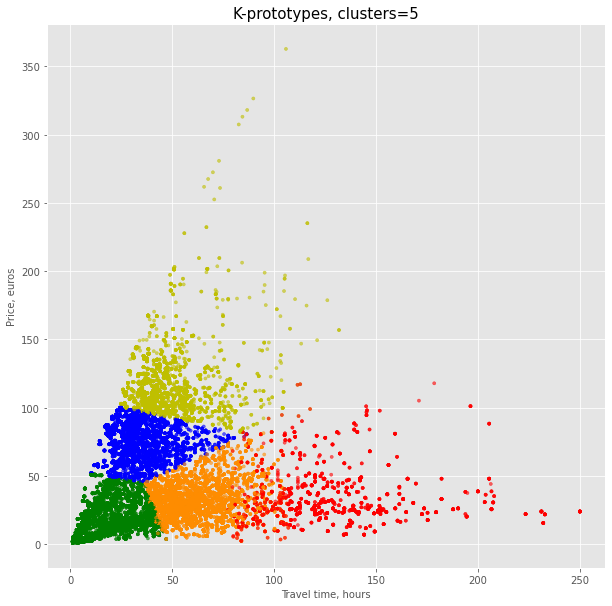

In [44]:
#we can conclude that the clusters were perfectly defined
#the data got clustered in the distinguishable way 
#just plot per two main dimensions

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(df5.totaltraveltimeinhours, df5.totalprice, c=df5.c, alpha = 0.6, s=10)

plt.xlabel("Travel time, hours", size = 10)
plt.ylabel("Price, euros", size = 10)
plt.title("K-prototypes, clusters=5", size = 15)

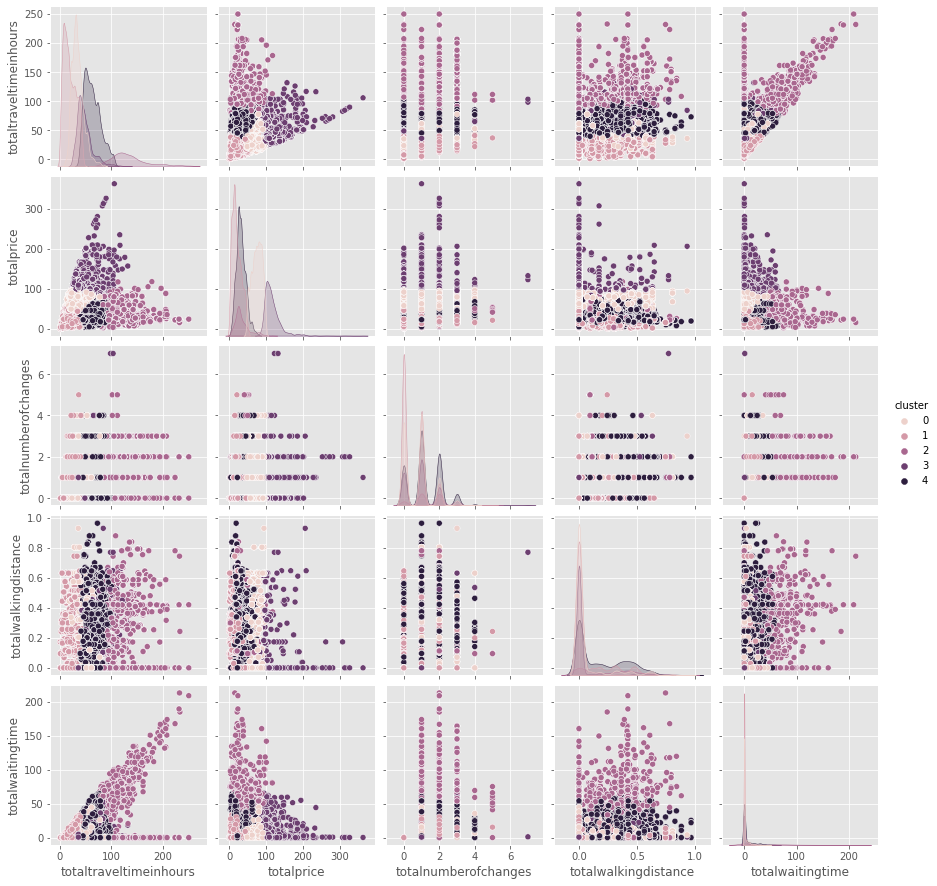

In [45]:
sns.pairplot(df5,vars=['totaltraveltimeinhours','totalprice','totalnumberofchanges','totalwalkingdistance', 'totalwaitingtime'],hue='cluster')

In [49]:
#investigate the 2d group (1 in clustering index), which has really interesting parameters
#subset the data
second = df5[df5["cluster"] == 1]
second

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,cluster,c
2,1.33,2.17,0,0.000,0.00,all,"[travelTime, price]",[db_fv],1,g
3,3.93,0.86,0,0.000,0.00,all,"[travelTime, price]",[flixbus],1,g
6,1.33,2.89,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv],1,g
7,1.33,2.17,0,0.000,0.00,ptOnly,"[travelTime, price]",[db_fv],1,g
8,3.93,0.86,0,0.000,0.00,ptOnly,"[travelTime, price]",[flixbus],1,g
...,...,...,...,...,...,...,...,...,...,...
85103,20.17,22.42,1,0.000,9.00,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],1,g
85104,20.17,19.62,2,0.000,10.17,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],1,g
85105,25.00,18.25,2,0.000,13.67,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],1,g
85106,30.33,17.64,2,0.000,19.33,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],1,g


In [50]:
#only 18 from 33 transports were involved, flight was excluded from this group
#print all unique values inside

for col in second:
    print(second[col].unique())
    print(second[col].nunique())

[ 1.33  3.93  2.53 39.84  9.5  11.31 19.33 29.5  15.5  25.5  10.62  3.03
  8.12  3.67  4.33  5.35  6.88 25.01 12.34 12.01 11.01 11.68 14.84 20.84
 21.84 28.34 12.68 31.68 30.01 15.34 28.   30.5  30.67 37.43 27.43  6.1
  7.6   9.83 14.1  27.67 36.77 17.83 28.33 12.73 18.17 18.   31.42 39.38
 25.   26.66  2.5   2.33  5.29 12.1   6.07  6.67  7.33  8.6  17.5  33.86
 19.86 27.   30.53 37.17  8.34  5.17  5.    3.18  8.95  8.83 33.17 14.6
 47.1  20.8  25.3  33.26 24.58 22.08 13.   17.08 31.75 35.77 35.83 17.12
 13.67 13.5  29.58 12.   12.33 23.95 36.28 27.5   7.34 18.19 20.   18.37
 25.41 14.98 22.91 32.13 20.67 19.17 32.08 23.   34.27 34.84 34.67 15.33
 27.27 31.17 14.77 25.26  1.5   3.96  5.63  3.86  1.83  1.67 18.38 18.9
  6.78 10.17  5.5  12.62  9.31 35.17 12.5  22.5  16.99 13.17 14.5   6.
  9.52  6.02 23.08 19.74 18.91 15.58 12.17 11.33 13.91 32.33 30.   32.17
 15.67 25.58 34.05 34.38 10.74 18.5  15.83 14.33 14.67  5.83  9.34  7.56
 43.38 24.83 19.   20.66 24.16 28.16 13.83 16.67 18.16 1

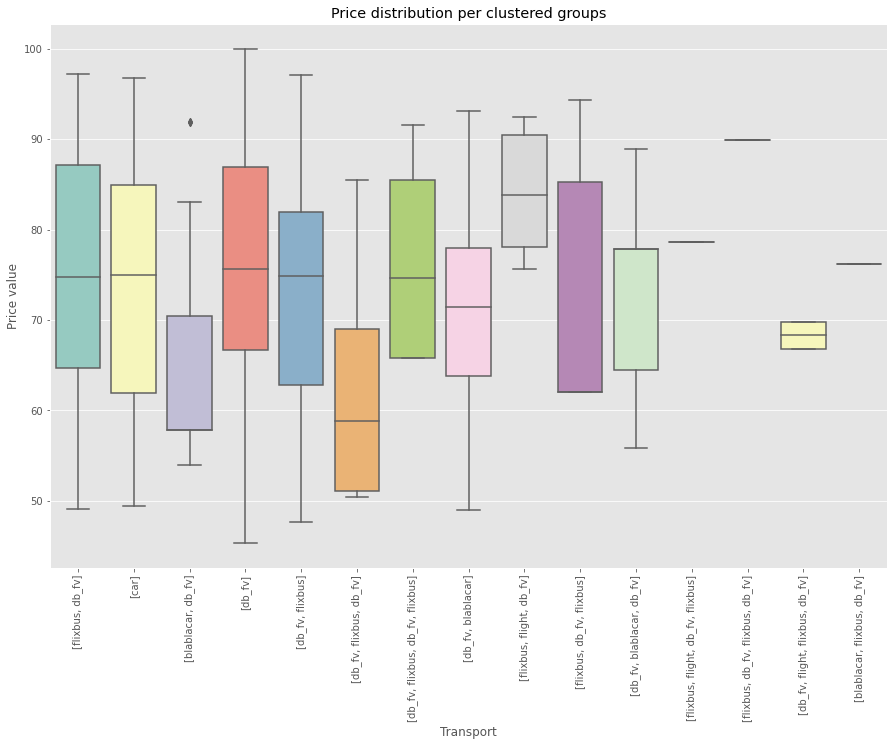

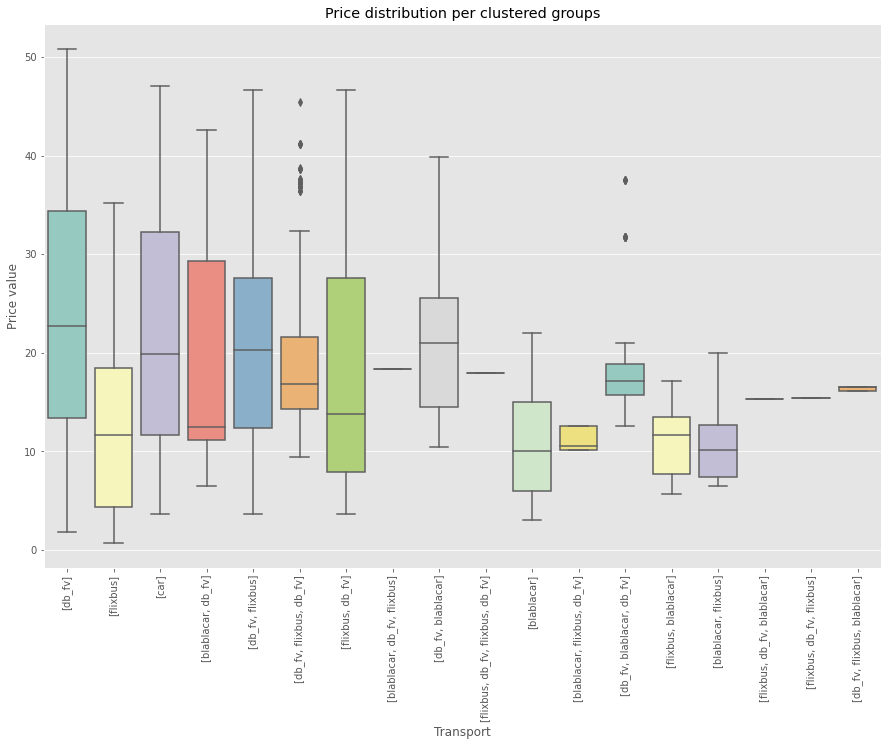

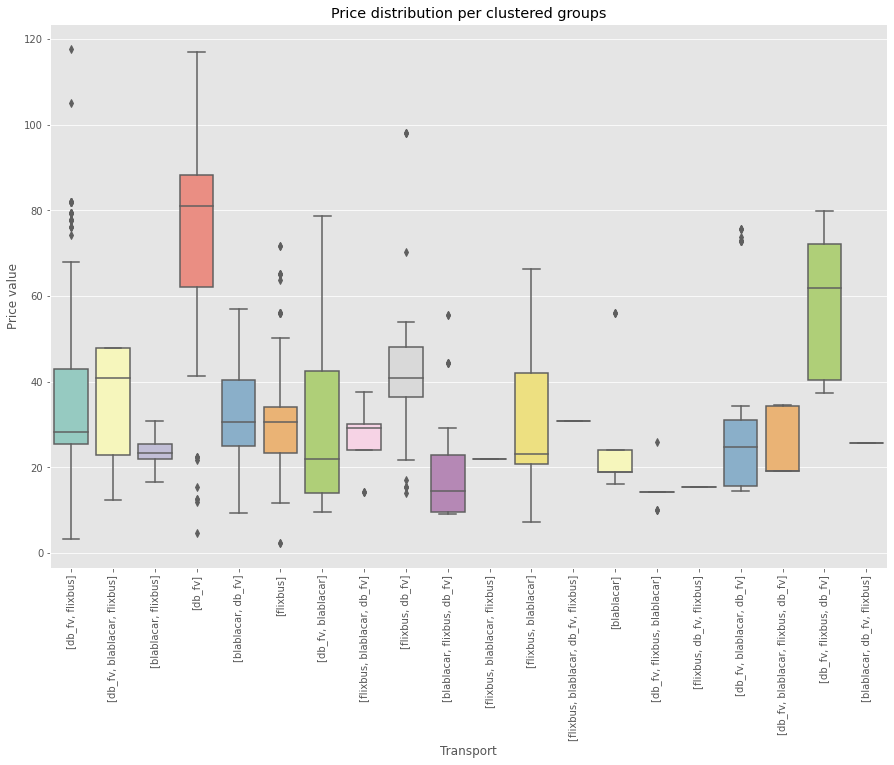

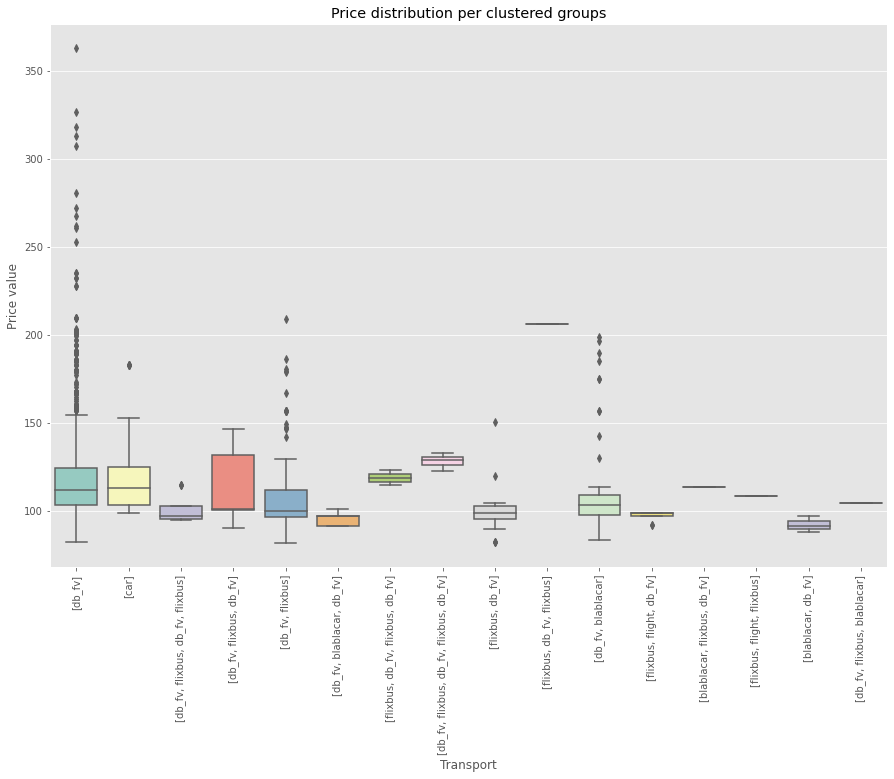

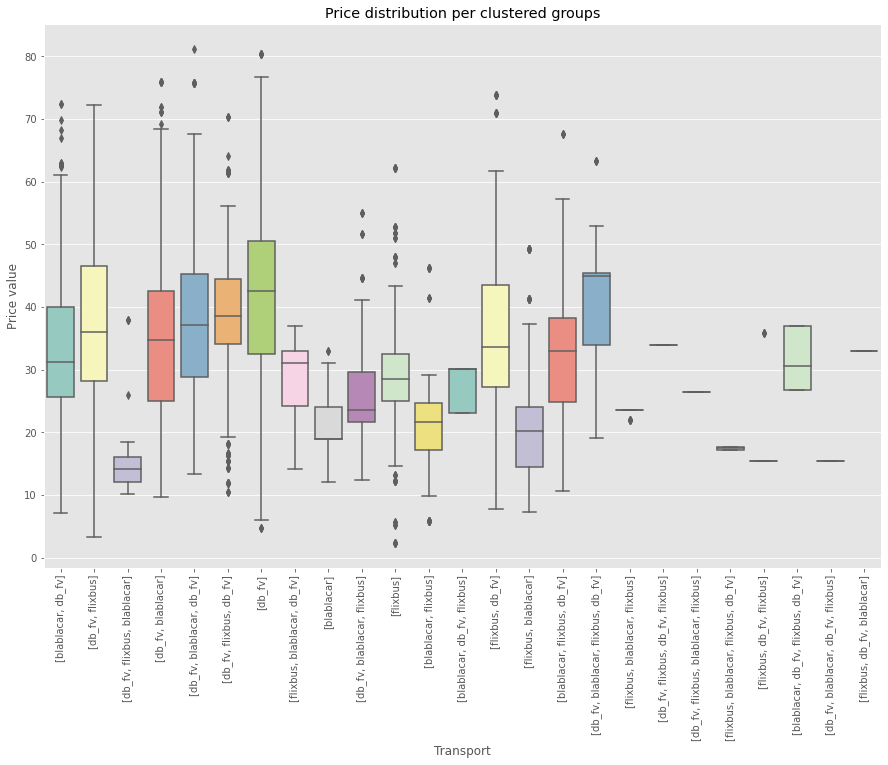

In [152]:
#plot the data to reveal the mode types involved- group 2 for instance,:
#18 combinations were involved
# in general the middle price value is below 25 euros in this group, third quartile for some modes as well, to generalise- below 35
#the very max of the price would be 51 euro for the train, however for some  solutions this is the zone for extreme outliers.
# we have no flights mode for this cluster

def plot0(datt):
  plt.figure(figsize=(15, 10))
  sns.boxplot(data=datt,x="finalsolutionusedlabels", y='totalprice',palette='Set3')#take care about variables of the data
  plt.title('Price distribution per clustered groups')
  plt.xticks(rotation='vertical')
  plt.xlabel('Transport')
  plt.ylabel("Price value")


plot0(cluster_1)
plot0(cluster_2)
plot0(cluster_3)
plot0(cluster_4)
plot0(cluster_5)

In [54]:
df6=df5.copy()

In [55]:
#investigate the second group again

df6['cluster'] = list(clusters) #obtain the clusters


In [57]:
#again check the results
cluster_2= df6[df6['cluster']== 1]
cluster_2.head(50) #get the results

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,cluster,c
2,1.33,2.17,0,0.000,0.0,all,"[travelTime, price]",[db_fv],1,g
3,3.93,0.86,0,0.000,0.0,all,"[travelTime, price]",[flixbus],1,g
6,1.33,2.89,0,0.000,0.0,ptOnly,"[travelTime, price]",[db_fv],1,g
7,1.33,2.17,0,0.000,0.0,ptOnly,"[travelTime, price]",[db_fv],1,g
8,3.93,0.86,0,0.000,0.0,ptOnly,"[travelTime, price]",[flixbus],1,g
11,1.33,2.89,0,0.000,0.0,noFlights,"[travelTime, price]",[db_fv],1,g
12,1.33,2.17,0,0.000,0.0,noFlights,"[travelTime, price]",[db_fv],1,g
13,3.93,0.86,0,0.000,0.0,noFlights,"[travelTime, price]",[flixbus],1,g
18,2.53,3.83,0,0.000,0.0,all,"[travelTime, price, numberofChanges]",[car],1,g
20,1.33,2.89,0,0.000,0.0,all,"[travelTime, price, numberofChanges]",[db_fv],1,g


In [97]:
#again check the results for 1 cluster
cluster_1= df6[df6['cluster']== 0]
cluster_1.head(50) #get the results

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,cluster,c
127,39.46,91.02,0,0.000,0.00,all,"[travelTime, price]","[flixbus, db_fv]",0,b
128,36.46,91.02,0,0.000,0.00,all,"[travelTime, price]","[flixbus, db_fv]",0,b
131,31.80,96.41,0,0.000,0.00,all,"[travelTime, price]","[flixbus, db_fv]",0,b
132,31.80,91.63,0,0.000,0.00,all,"[travelTime, price]","[flixbus, db_fv]",0,b
133,34.80,91.13,0,0.000,0.00,all,"[travelTime, price]","[flixbus, db_fv]",0,b
138,39.46,91.02,0,0.000,0.00,ptOnly,"[travelTime, price]","[flixbus, db_fv]",0,b
139,36.46,91.02,0,0.000,0.00,ptOnly,"[travelTime, price]","[flixbus, db_fv]",0,b
142,31.80,96.41,0,0.000,0.00,ptOnly,"[travelTime, price]","[flixbus, db_fv]",0,b
143,31.80,91.63,0,0.000,0.00,ptOnly,"[travelTime, price]","[flixbus, db_fv]",0,b
144,34.80,91.13,0,0.000,0.00,ptOnly,"[travelTime, price]","[flixbus, db_fv]",0,b


In [98]:
#again check the results for 3 cluster
cluster_3= df6[df6['cluster']== 2]
cluster_3.head(50) #get the results

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,cluster,c
567,105.35,4.62,1,0.300,100.09,ptOnly,"[travelTime, price, numberofChanges, walkingDi...","[db_fv, flixbus]",2,r
2120,108.03,36.81,1,0.000,0.00,ptOnly,"[travelTime, price, numberofChanges]","[db_fv, flixbus]",2,r
2289,90.53,29.91,2,0.477,65.25,ptOnly,"[travelTime, price, numberofChanges, walkingDi...","[db_fv, blablacar, flixbus]",2,r
2337,90.53,29.91,2,0.477,65.25,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[db_fv, blablacar, flixbus]",2,r
2712,111.14,21.75,0,0.000,0.00,all,"[travelTime, price]","[blablacar, flixbus]",2,r
2714,232.81,21.75,0,0.000,0.00,ptOnly,"[travelTime, price]","[blablacar, flixbus]",2,r
2733,111.14,21.75,0,0.000,0.00,ptOnly,"[travelTime, price]","[blablacar, flixbus]",2,r
2734,232.81,21.75,0,0.000,0.00,noFlights,"[travelTime, price]","[blablacar, flixbus]",2,r
2753,111.14,21.75,0,0.000,0.00,noFlights,"[travelTime, price]","[blablacar, flixbus]",2,r
2778,111.14,21.75,2,0.000,0.00,all,"[travelTime, price, numberofChanges]","[blablacar, flixbus]",2,r


In [99]:
#again check the results for 4 cluster
cluster_4= df6[df6['cluster']== 3]
cluster_4.head(50) #get the results

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,cluster,c
225,77.67,96.05,2,0.0,0.00,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],3,y
274,77.67,96.05,2,0.0,46.00,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],3,y
295,77.67,96.05,2,0.0,45.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],3,y
1485,48.33,126.63,1,0.0,2.00,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],3,y
2314,41.17,170.29,3,0.0,1.83,ptOnly,"[travelTime, price, numberofChanges, walkingDi...",[db_fv],3,y
2362,41.00,134.35,0,0.0,0.00,all,"[travelTime, price]",[db_fv],3,y
2363,43.67,129.10,0,0.0,0.00,all,"[travelTime, price]",[db_fv],3,y
2364,46.52,122.57,0,0.0,0.00,all,"[travelTime, price]",[car],3,y
2365,46.83,101.51,0,0.0,0.00,all,"[travelTime, price]",[db_fv],3,y
2366,48.83,97.47,0,0.0,0.00,all,"[travelTime, price]",[db_fv],3,y


In [101]:
#again check the results for 4 cluster
cluster_5= df6[df6['cluster']== 4]
cluster_5.head(50) #get the results

,totaltraveltimeinhours,totalprice,totalnumberofchanges,totalwalkingdistance,totalwaitingtime,finiteautomaton,consideredpreferences,finalsolutionusedlabels,cluster,c
135,55.68,22.47,0,0.000,0.00,all,"[travelTime, price]","[blablacar, db_fv]",4,darkorange
146,55.68,22.47,0,0.000,0.00,ptOnly,"[travelTime, price]","[blablacar, db_fv]",4,darkorange
157,55.68,22.47,0,0.000,0.00,noFlights,"[travelTime, price]","[blablacar, db_fv]",4,darkorange
168,55.68,22.47,1,0.000,0.00,all,"[travelTime, price, numberofChanges]","[blablacar, db_fv]",4,darkorange
175,55.68,22.47,1,0.000,0.00,ptOnly,"[travelTime, price, numberofChanges]","[blablacar, db_fv]",4,darkorange
188,55.68,22.47,1,0.000,0.00,noFlights,"[travelTime, price, numberofChanges]","[blablacar, db_fv]",4,darkorange
203,55.68,22.47,1,0.383,0.00,all,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]",4,darkorange
222,55.68,27.43,2,0.273,0.00,ptOnly,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]",4,darkorange
223,55.68,22.47,1,0.383,0.00,ptOnly,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]",4,darkorange
240,55.68,22.47,1,0.383,0.00,noFlights,"[travelTime, price, numberofChanges, walkingDi...","[blablacar, db_fv]",4,darkorange


In [106]:
def minvalue(data):
  minvalue = data[['totaltraveltimeinhours', 'totalwaitingtime', 'totalnumberofchanges',	'totalwalkingdistance',	'totalprice']].min()
  print("minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': ")
  print(minvalue)

minvalue(cluster_1)
minvalue(cluster_2)
minvalue(cluster_3)
minvalue(cluster_4)
minvalue(cluster_5)

minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    10.33
totalwaitingtime           0.00
totalnumberofchanges       0.00
totalwalkingdistance       0.00
totalprice                45.35
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    1.18
totalwaitingtime          0.00
totalnumberofchanges      0.00
totalwalkingdistance      0.00
totalprice                0.72
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    77.36
totalwaitingtime           0.00
totalnumberofchanges       0.00
totalwalkingdistance       0.00
totalprice                 2.35
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totaln

In [109]:
#investigate the group with respect to max value
def maxvalue(d):
  maxvalue = d[['totaltraveltimeinhours', 'totalwaitingtime', 'totalnumberofchanges',	'totalwalkingdistance',	'totalprice']].max()
  print("minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': ")
  print(maxvalue)

maxvalue(cluster_1)
maxvalue(cluster_2)
maxvalue(cluster_3)
maxvalue(cluster_4)
maxvalue(cluster_5)

#the range would be from 1 hour to 47 hours,0-36 waiting hours, 0-5 changes,0-0.745 walking distance, 0.72-50.840 for the price

minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    86.500
totalwaitingtime          49.670
totalnumberofchanges       4.000
totalwalkingdistance       0.931
totalprice                99.990
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    47.100
totalwaitingtime          36.500
totalnumberofchanges       5.000
totalwalkingdistance       0.745
totalprice                50.840
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    249.960
totalwaitingtime          212.860
totalnumberofchanges        5.000
totalwalkingdistance        0.881
totalprice                117.780
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 't

In [111]:
#investigate the group with respect to max value
def meanvalue(dat):
  meanvalue = dat[['totaltraveltimeinhours', 'totalwaitingtime', 'totalnumberofchanges',	'totalwalkingdistance',	'totalprice']].mean()
  print("minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': ")
  print(meanvalue)

meanvalue(cluster_1)
meanvalue(cluster_2)
meanvalue(cluster_3)
meanvalue(cluster_4)
meanvalue(cluster_5)

#basically the centroids again

minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    34.235340
totalwaitingtime           1.805438
totalnumberofchanges       0.790712
totalwalkingdistance       0.055470
totalprice                74.560593
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    19.216732
totalwaitingtime           1.288984
totalnumberofchanges       0.533687
totalwalkingdistance       0.087351
totalprice                20.147452
dtype: float64
minimum value in column 'totalTravelTimeInHours' & 'totalWaitingTime & 'totalnumberofchanges & 'totalwalkingdistance & 'totalprice': 
totaltraveltimeinhours    131.903642
totalwaitingtime           35.510787
totalnumberofchanges        1.514730
totalwalkingdistance        0.251040
totalprice                 34.279539
dtype: float64
minimum 

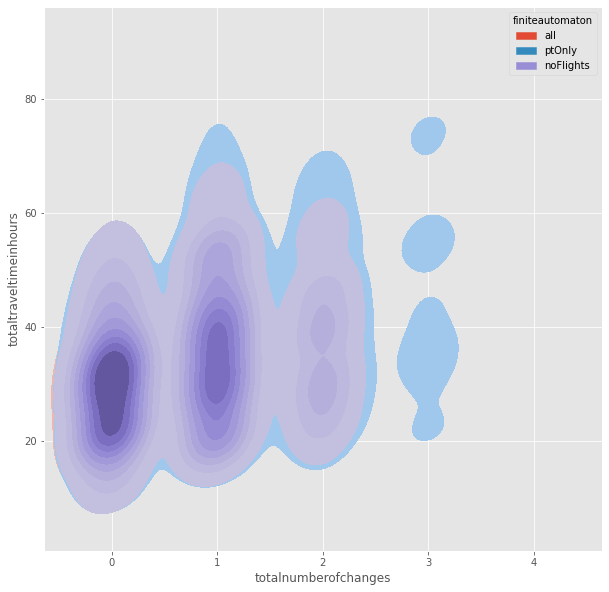

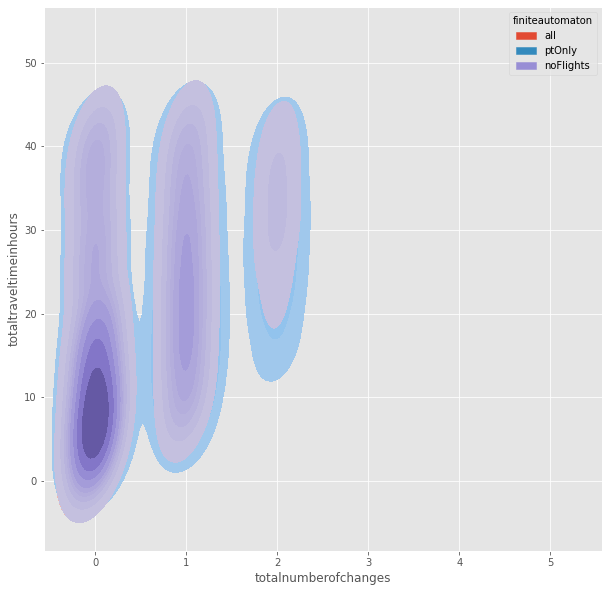

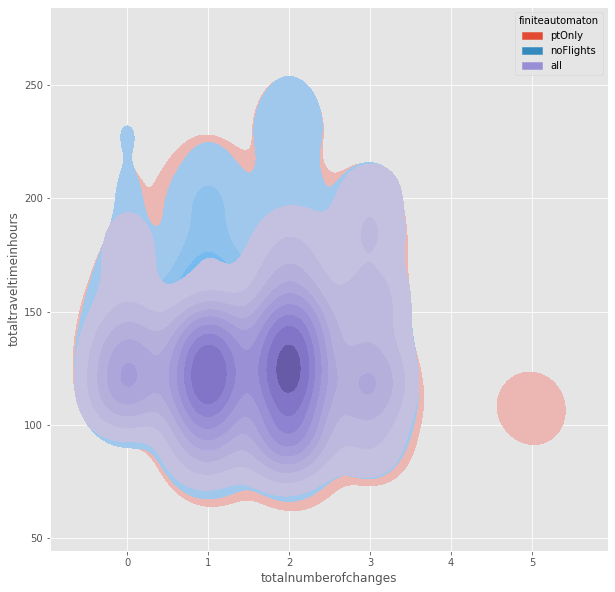

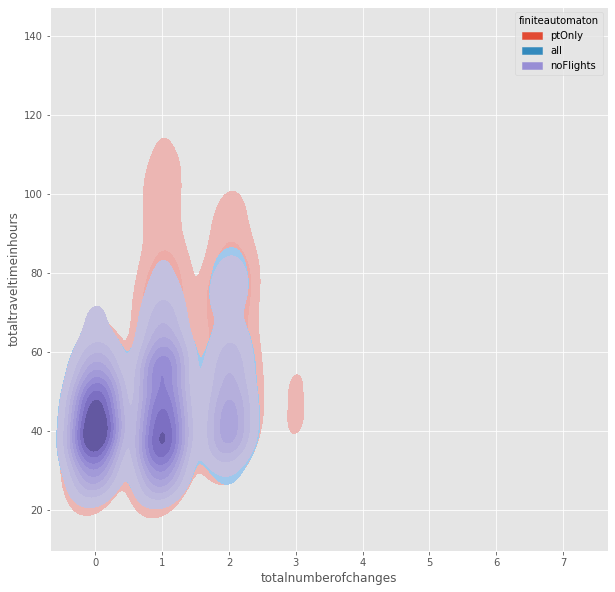

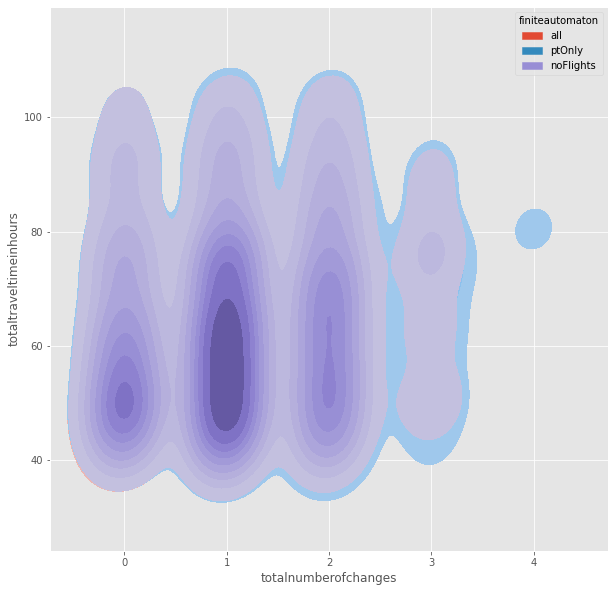

In [120]:
#get a 2 dimensional kernel density estimation (estimate of probability density) of cluster2 using number of changes and traveltime
# the group is not really dense havin all types of mode, mostly about publick transport and noflights, for 0 transfers the most densed area is from 3 to 13 hours
def plot1(data):
  plt.figure(figsize=(10,10))#check the size
  sns.kdeplot(x=data.totalnumberofchanges,y=data.totaltraveltimeinhours,hue=data.finiteautomaton,shade=True)
  plt.title('Density estimation per clustered groups')
  plt.xlabel('Transfers')
  plt.ylabel("Travel time")

plot1(cluster_1)
plot1(cluster_2)
plot1(cluster_3)
plot1(cluster_4)
plot1(cluster_5)

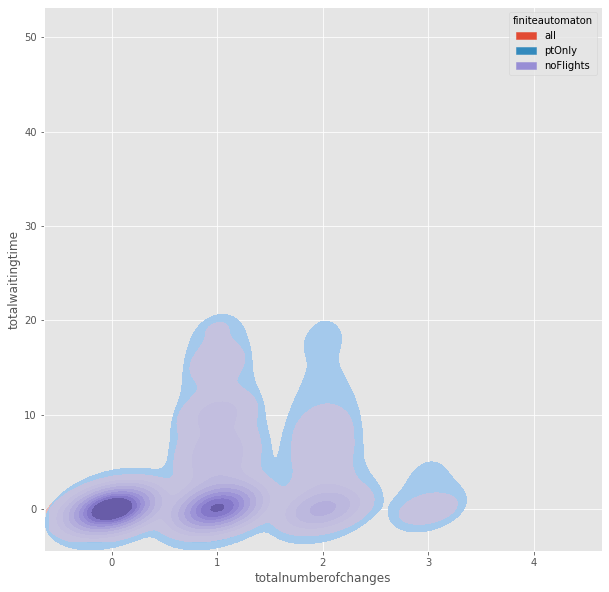

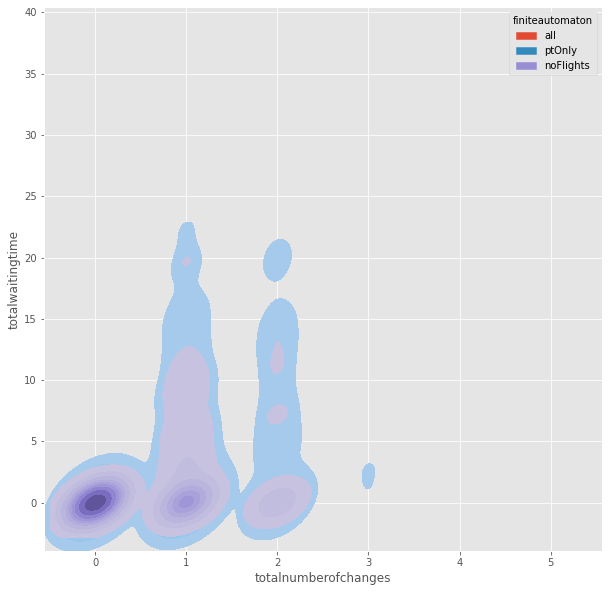

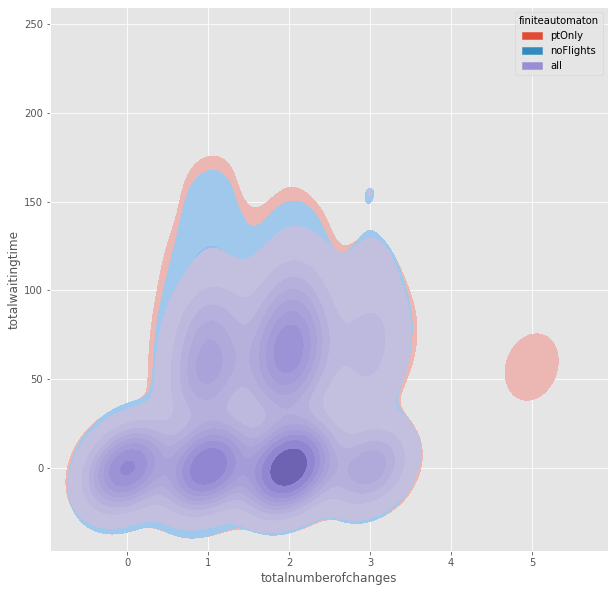

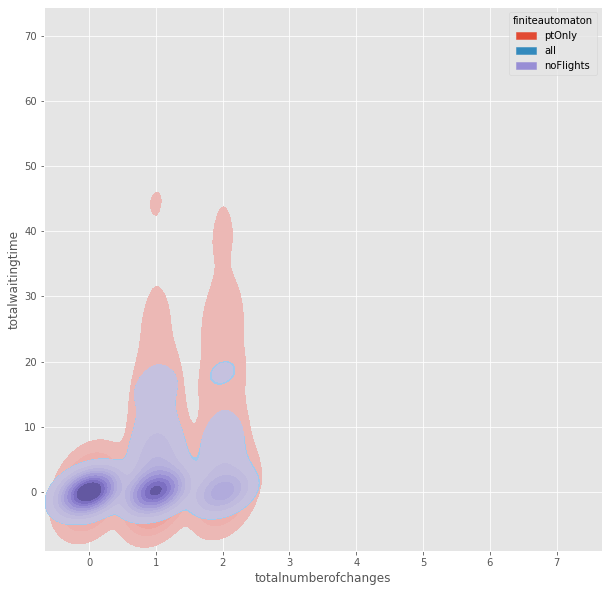

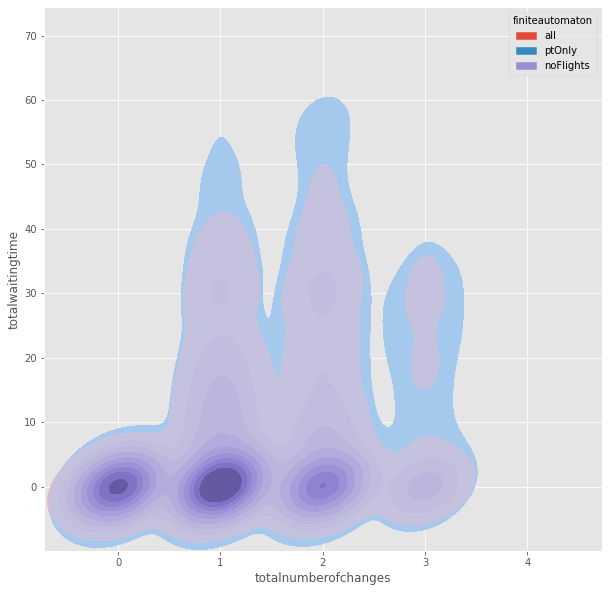

In [121]:
#get a 2 dimensional kernel density estimation (estimate of probability density) of cluster2 using number of changes and waiting time since they have the degree of correlation
# the group is not really dense having all types of mode, mostly about public transport ,
#public transport-waiting time is more
#the most densed area is 0-1 hour for waiting time when number of changes is 0
def plot2(data):
  plt.figure(figsize=(10,10))#check the size
  sns.kdeplot(x=data.totalnumberofchanges,y=data.totalwaitingtime,hue=data.finiteautomaton,shade=True)
  plt.title('Density estimation per clustered groups')
  plt.xlabel('Transfers')
  plt.ylabel("Waiting time")

plot2(cluster_1)
plot2(cluster_2)
plot2(cluster_3)
plot2(cluster_4)
plot2(cluster_5)

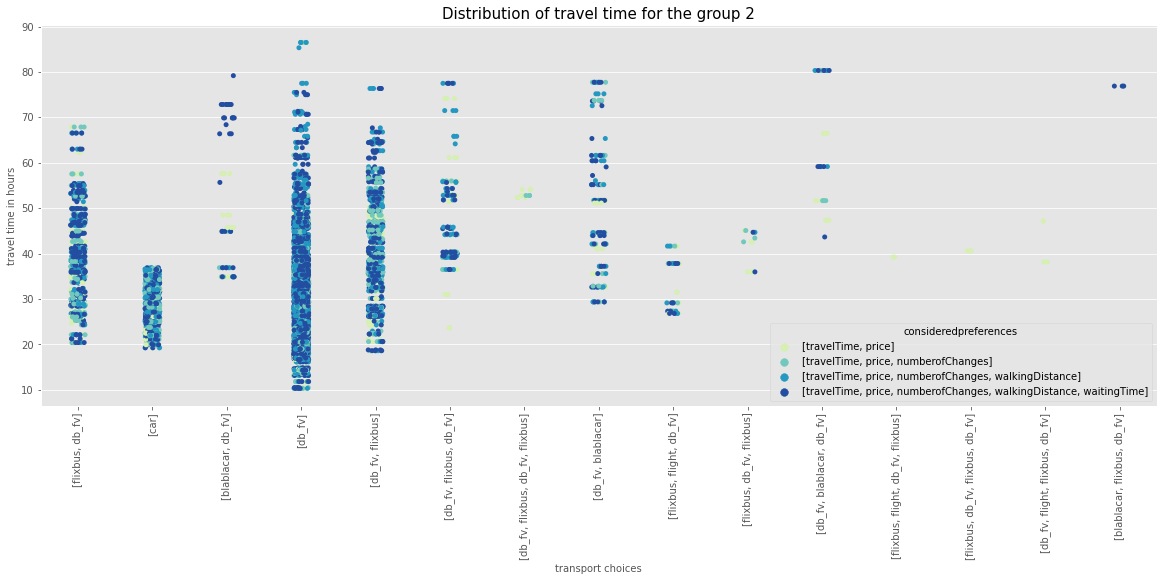

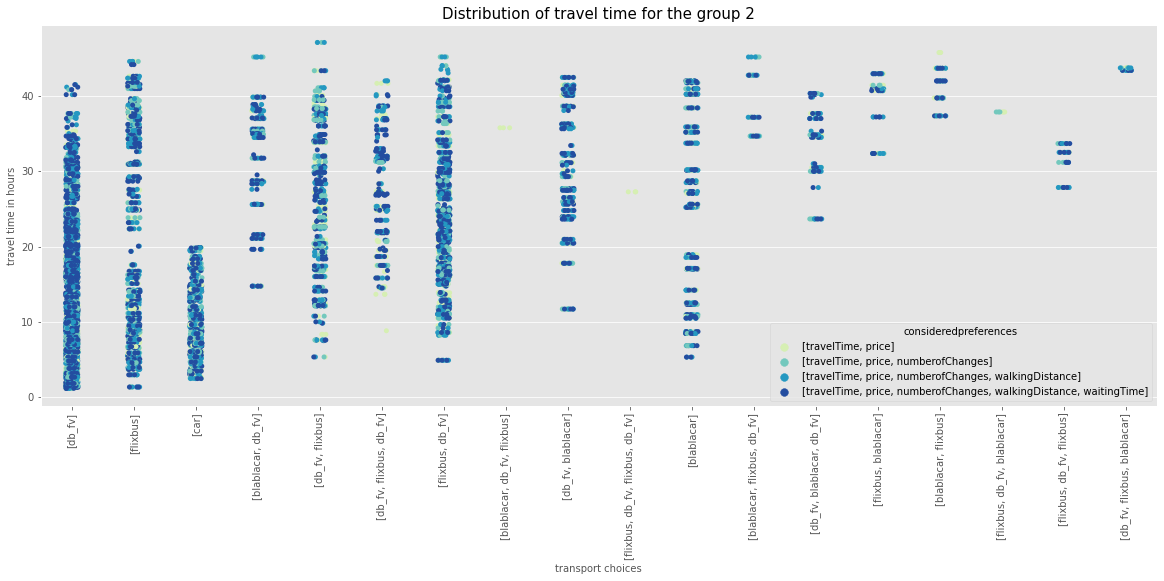

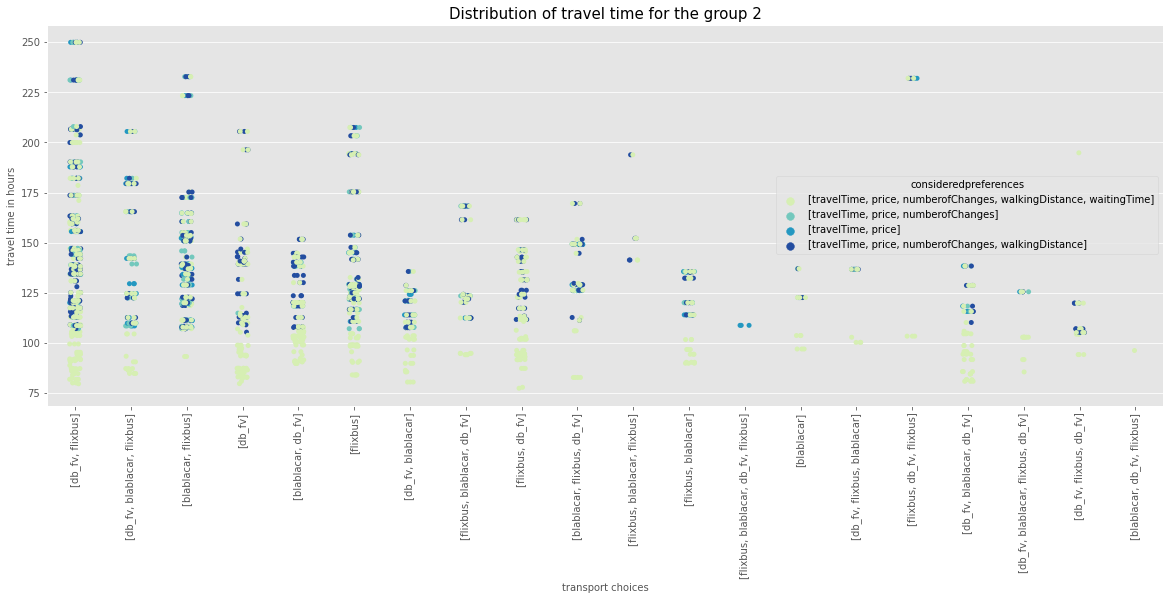

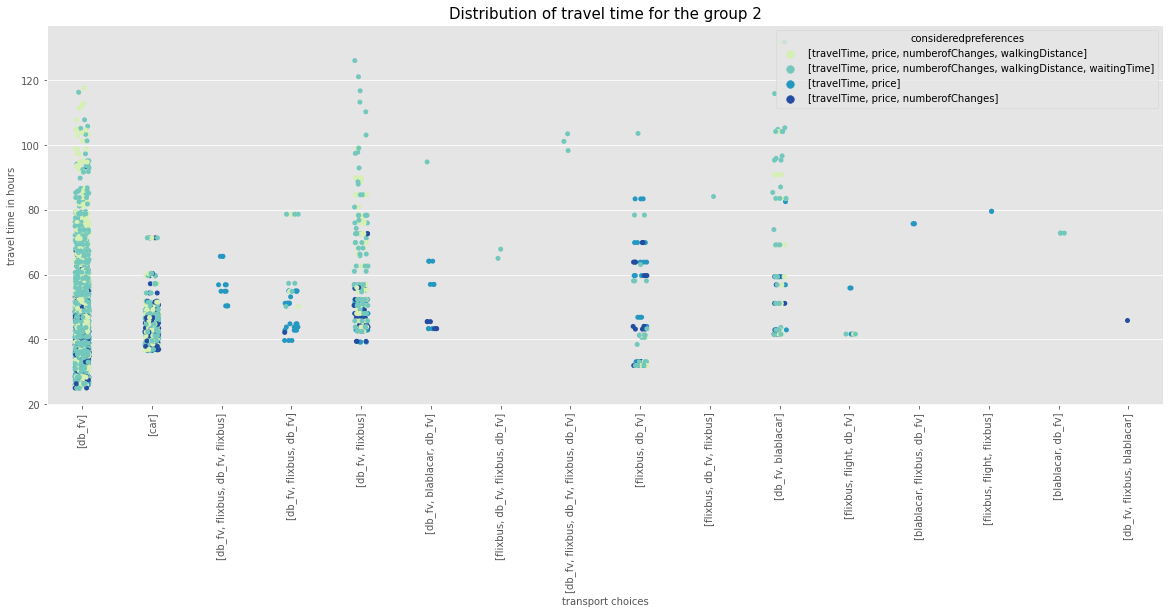

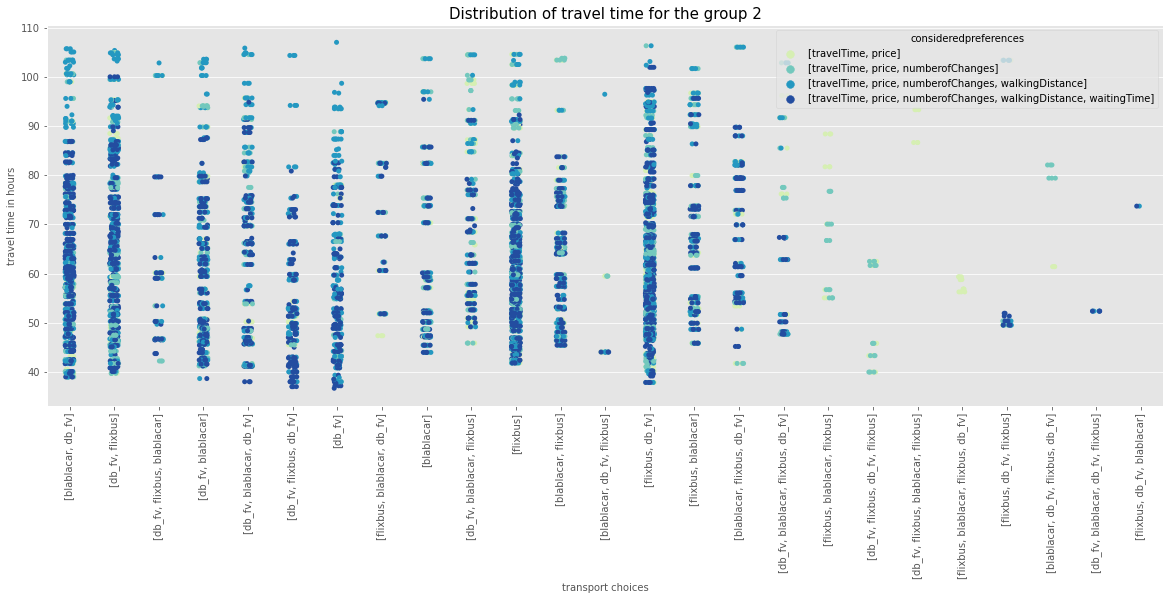

In [123]:
#cluster 2-observed that the majprity of distribution lies between 2 and 50 hours
# for the train mostly considered all preferences
#3 preferences the highest travel time in hours for blablacar+train, train+flixbus


def plot3(data):
  plt.figure(figsize=(20, 7))

  sns.stripplot(x=data['finalsolutionusedlabels'],y=data['totaltraveltimeinhours'],hue=data['consideredpreferences'],palette='YlGnBu')#configure the axis
  plt.xlabel("transport choices", size = 10)
  plt.xticks(rotation='vertical')
  plt.ylabel("travel time in hours", size = 10)
  plt.title('Distribution of travel time for the clustered groups',fontsize=15)

plot3(cluster_1)
plot3(cluster_2)
plot3(cluster_3)
plot3(cluster_4)
plot3(cluster_5)  

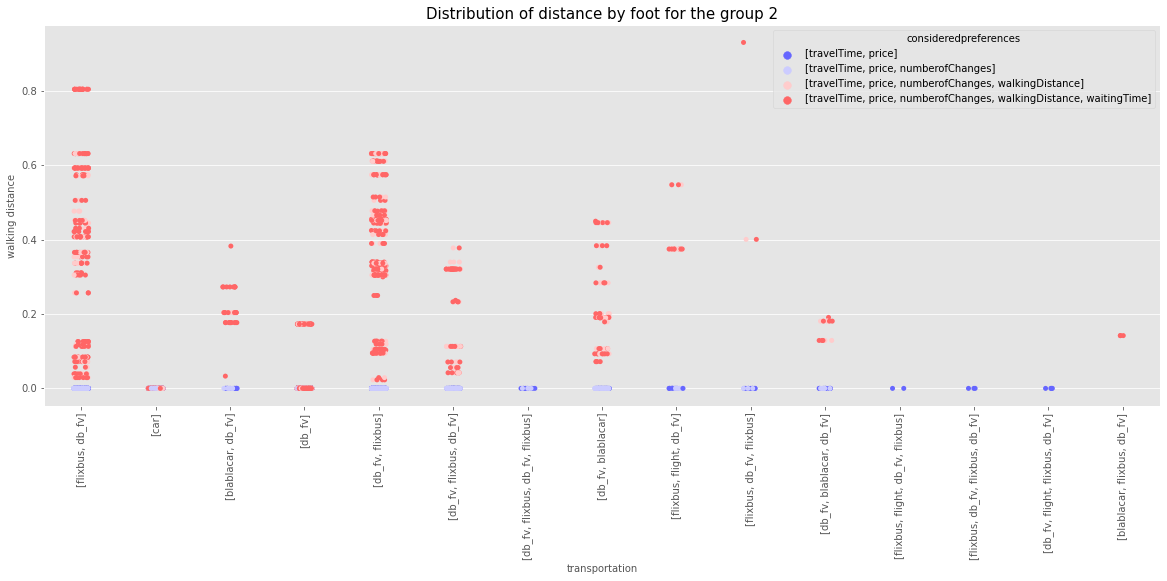

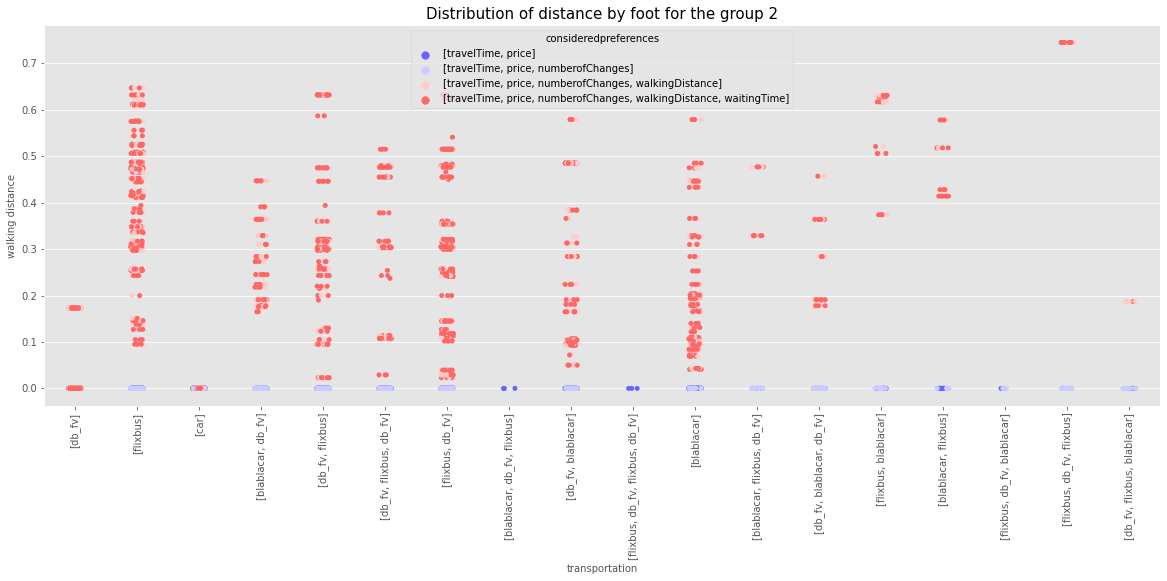

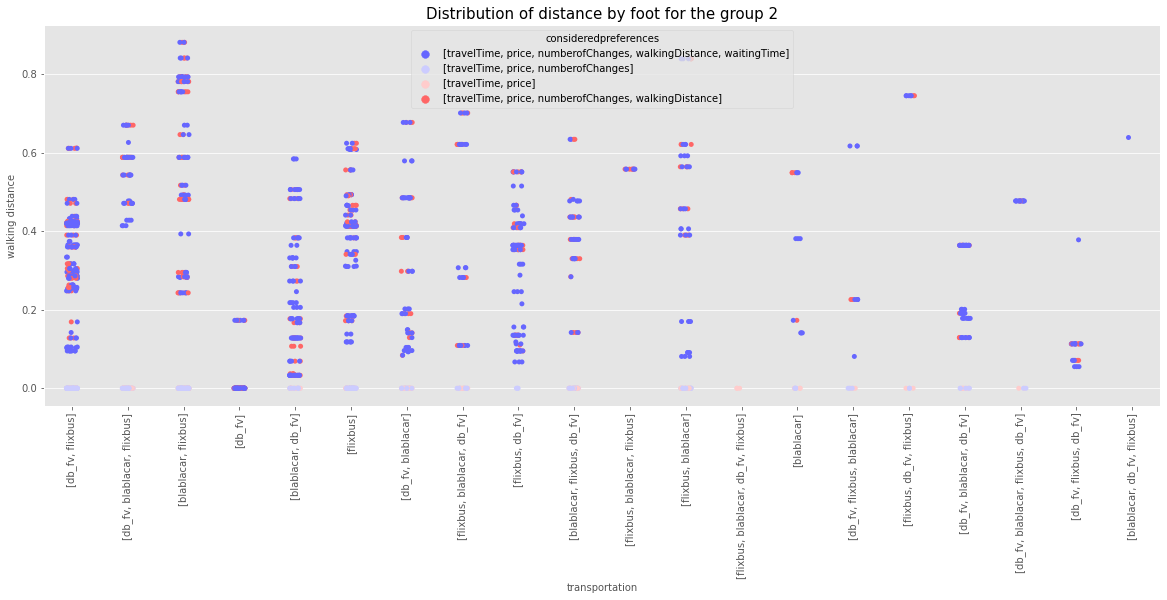

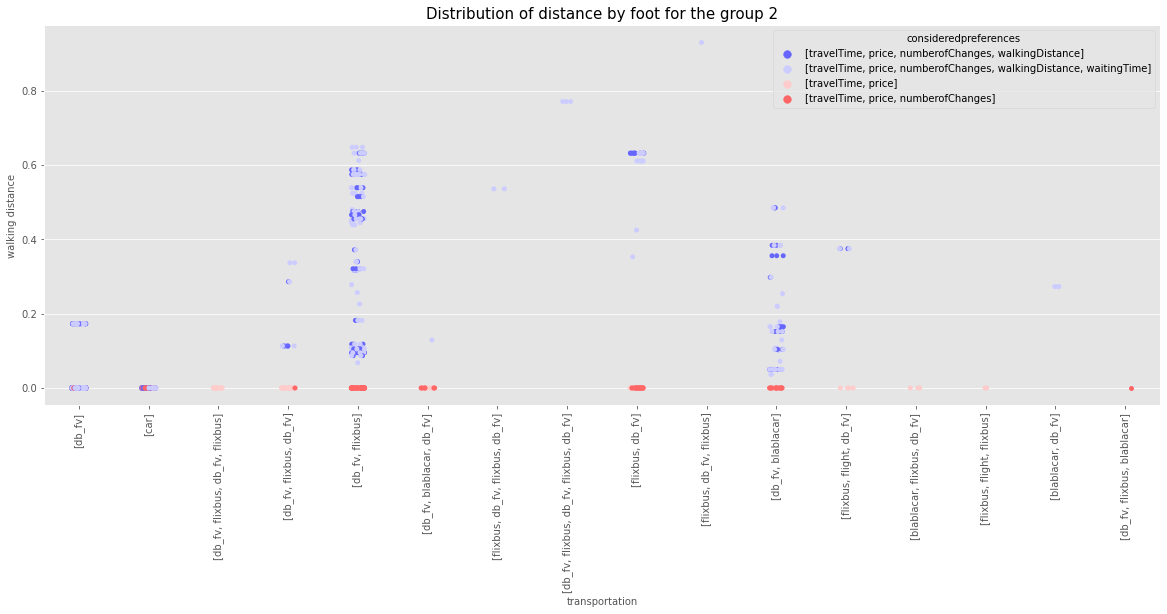

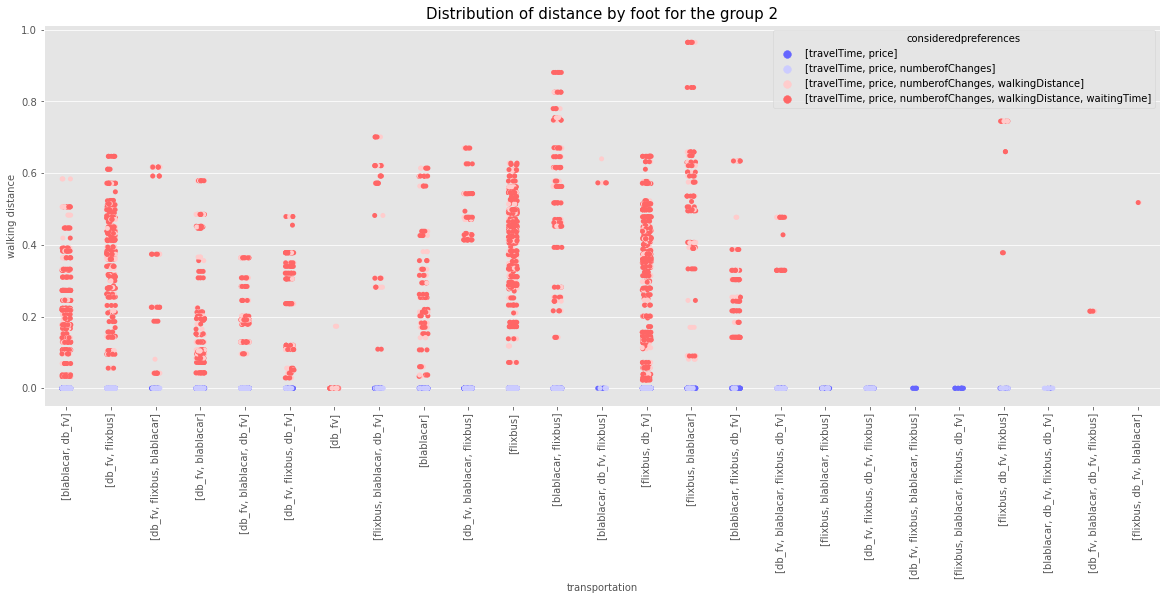

In [125]:
#cluster 2-0 distance by foot normally having  3 combinations within preference list

def plot4(data):
  plt.figure(figsize=(20, 7))

  sns.stripplot(x=data['finalsolutionusedlabels'],y=data['totalwalkingdistance'],hue=data['consideredpreferences'],palette='bwr')#configure the axis
  plt.xlabel("transportation", size = 10)
  plt.xticks(rotation='vertical')
  plt.ylabel("walking distance", size = 10)
  plt.title('Distribution of distance by foot for the clustered groups',fontsize=15)

plot4(cluster_1)
plot4(cluster_2)
plot4(cluster_3)
plot4(cluster_4)
plot4(cluster_5) 

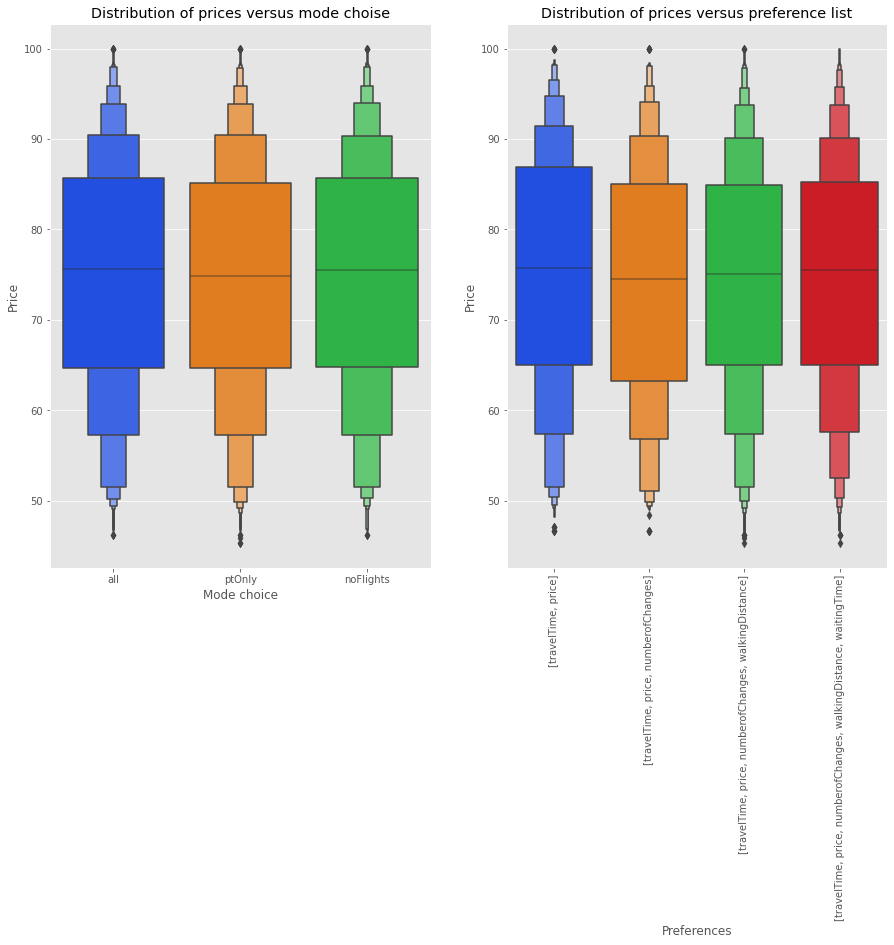

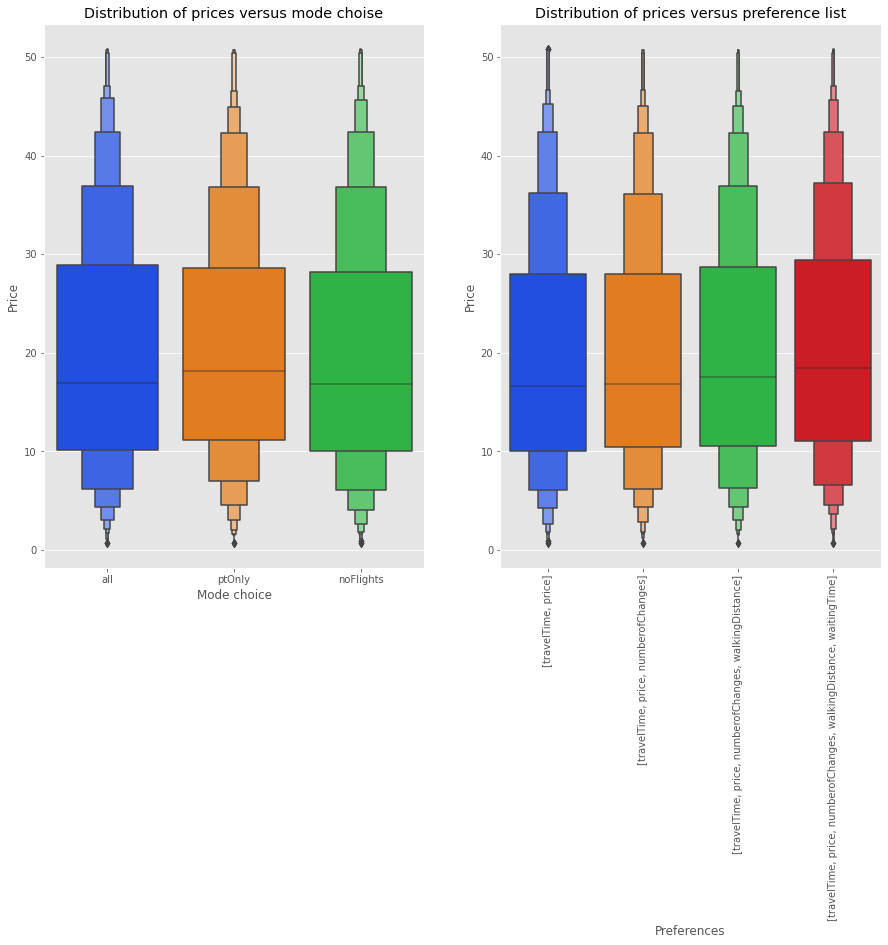

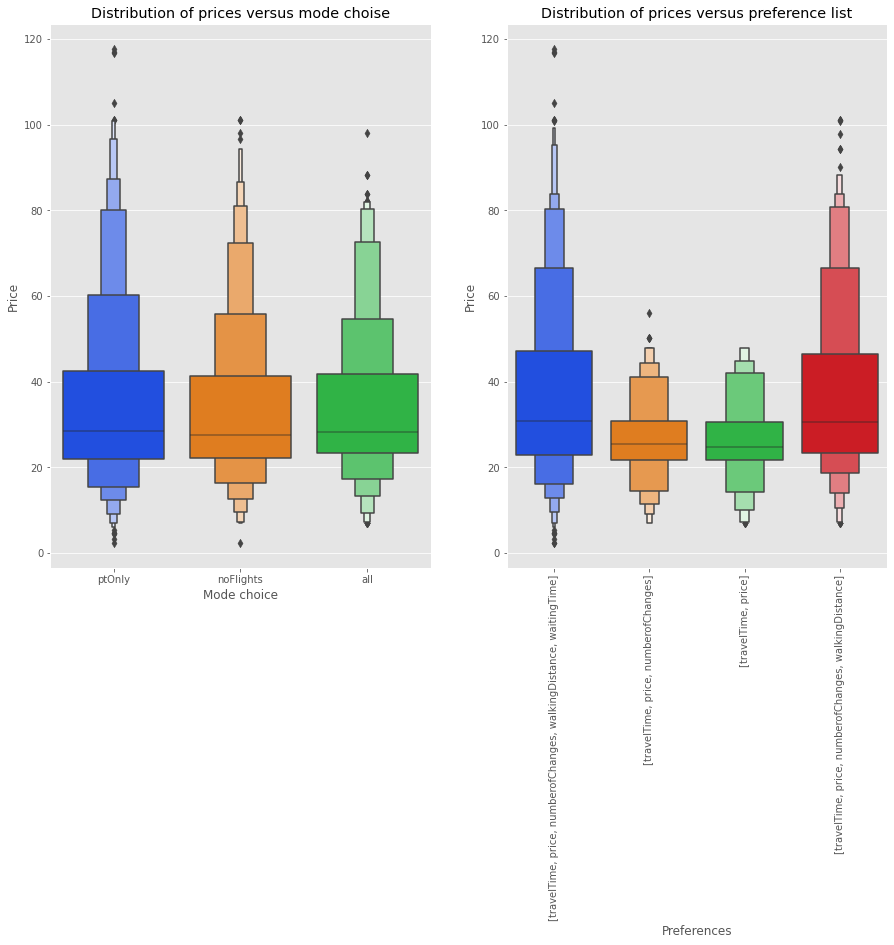

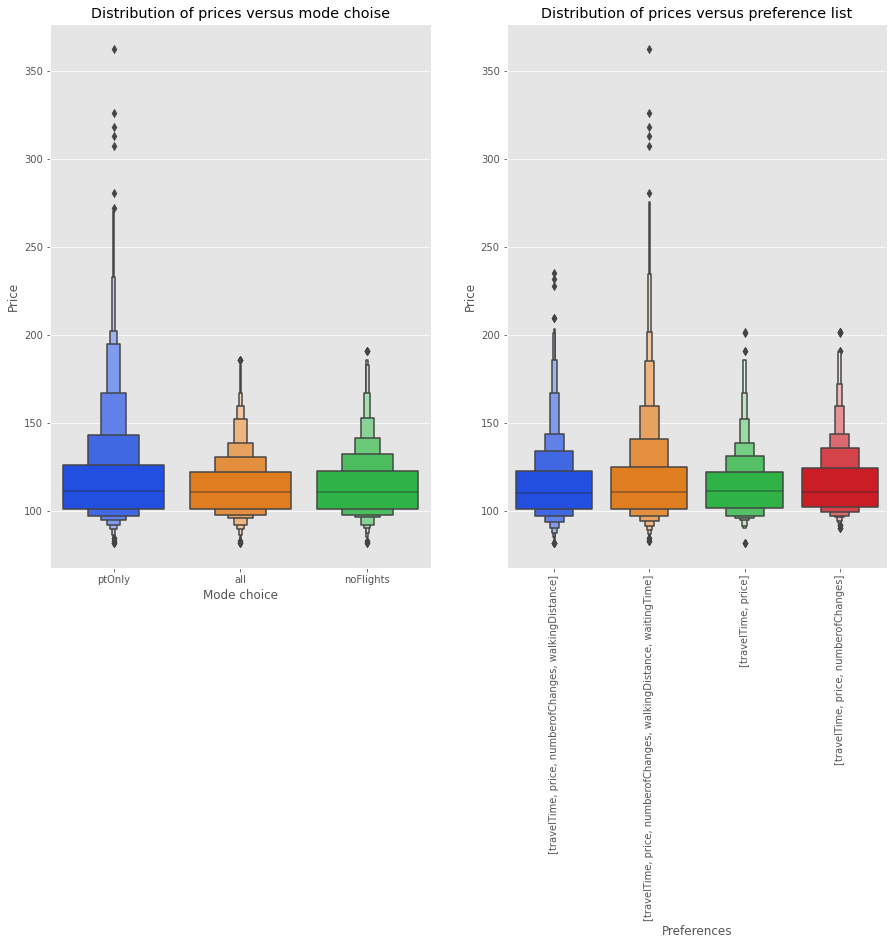

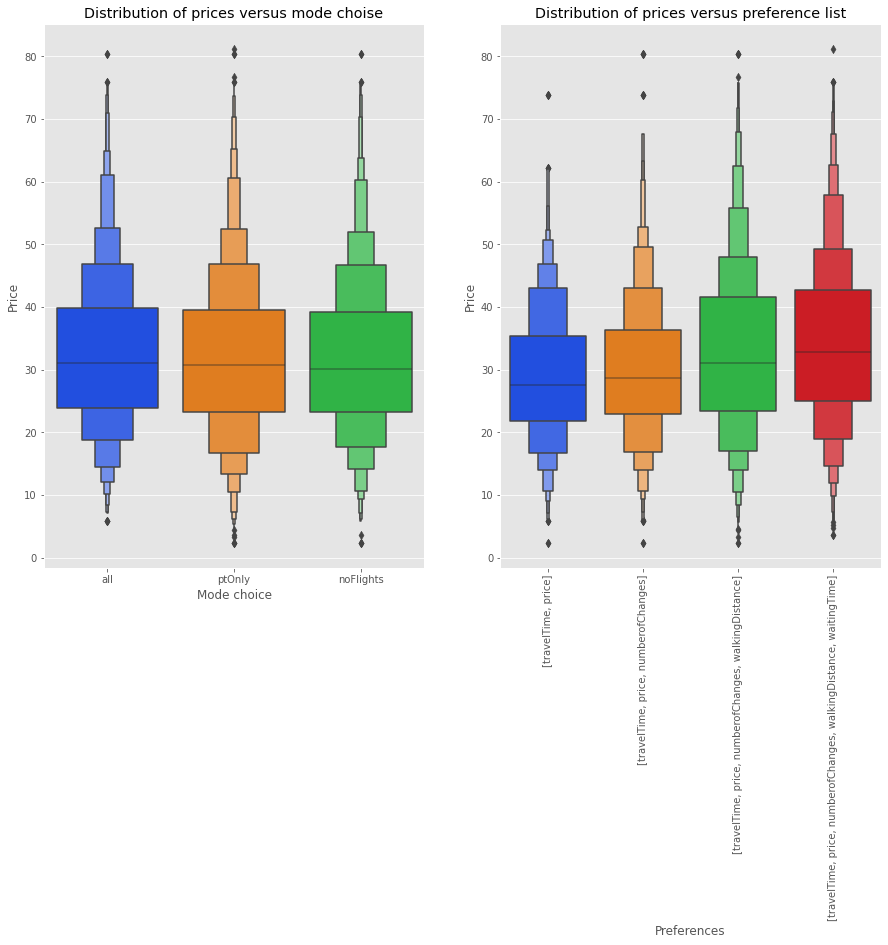

In [126]:


def plot5(dat):
  fig, axes = plt.subplots(1,2,figsize=(15,10))#unpack the tuple into the variables fig and axes
#cluster 2-normally between 10 and 30
  plt.subplot(121)
  sns.boxenplot(data=dat, x='finiteautomaton',y='totalprice',palette='bright') #pick the inner parametres for plotting
  plt.title('Distribution of prices versus mode choise')
  plt.xlabel('Mode choice')
  plt.ylabel("Price")


#cluster2- we can observe logical distribution of prices depending on preferences-same pattern
  plt.subplot(122)
  sns.boxenplot(data=dat, x='consideredpreferences',y='totalprice',palette='bright')#pick the inner parametres for plotting
  plt.xticks(rotation='vertical')
  plt.title('Distribution of prices versus preference list')
  plt.xlabel('Preferences')
  plt.ylabel("Price")

plot5(cluster_1)
plot5(cluster_2)
plot5(cluster_3)
plot5(cluster_4)
plot5(cluster_5) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


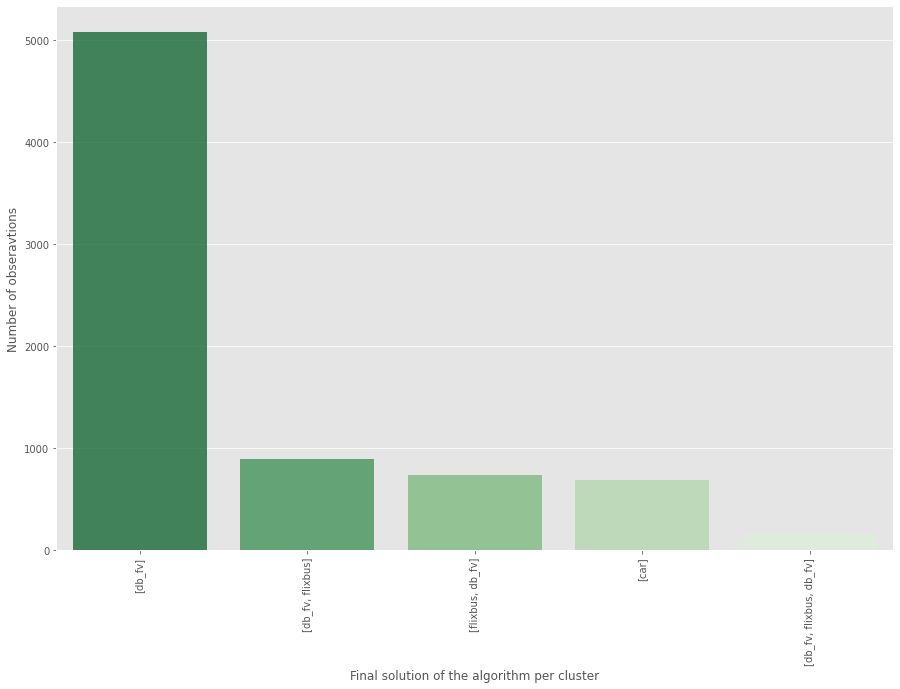

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


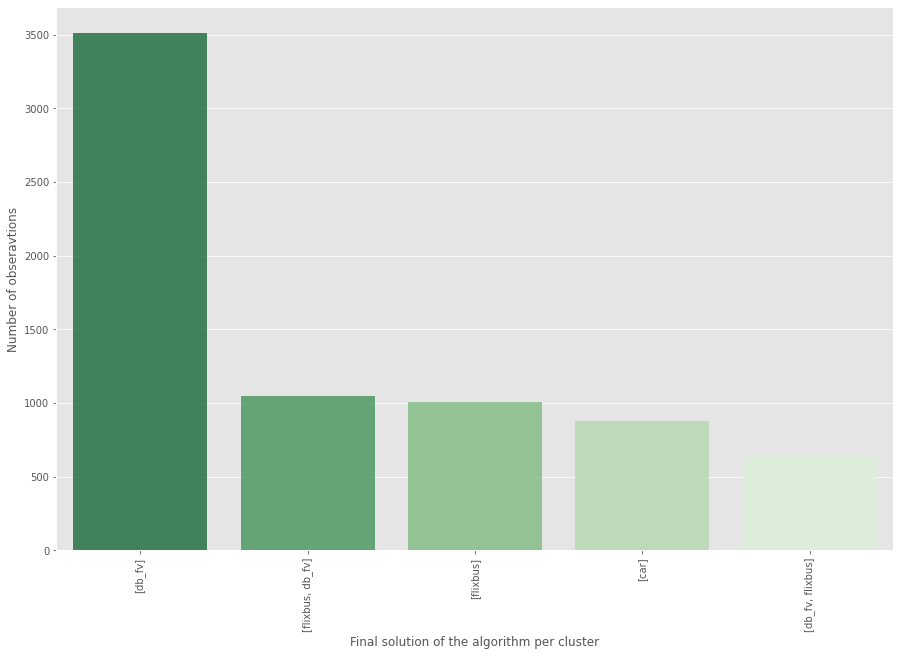

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


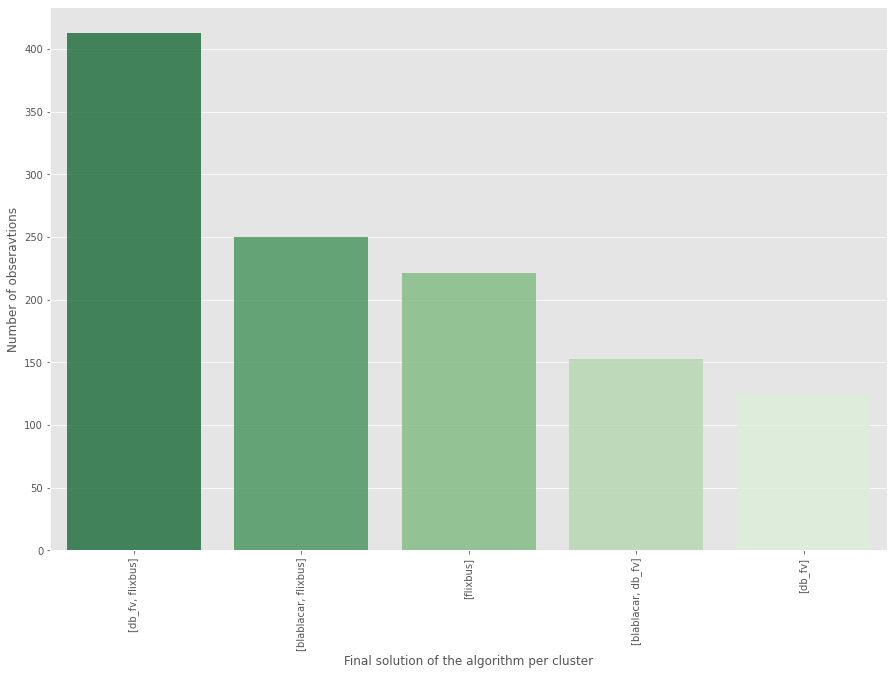

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


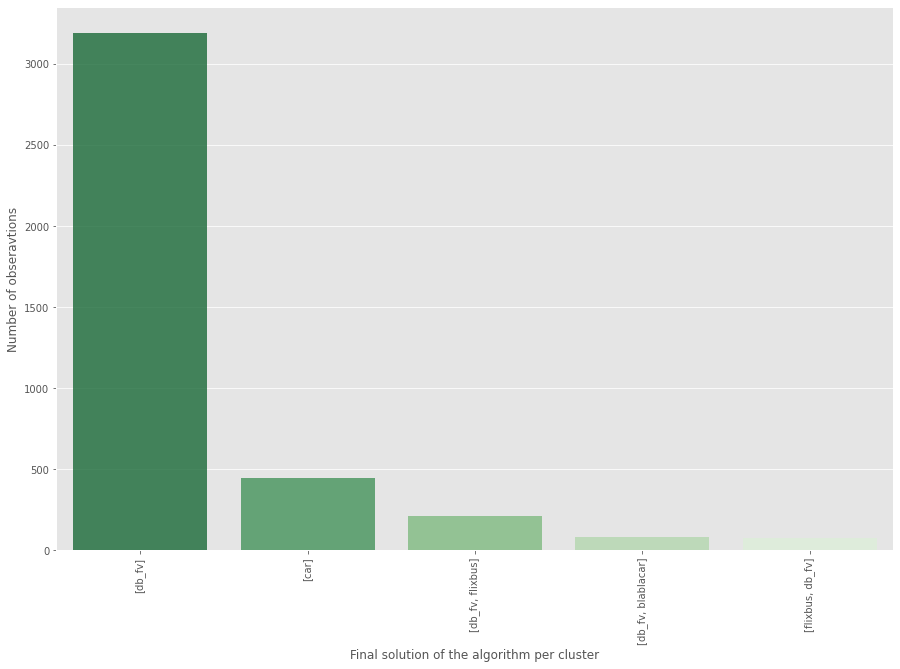

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


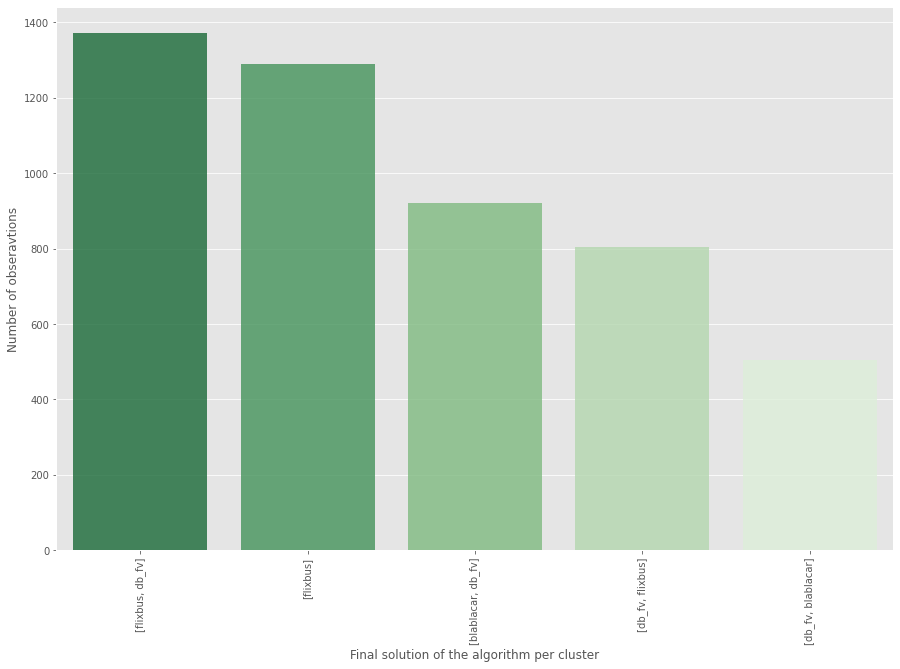

In [127]:
def plot6(data):
# top proposed solutions
  cnt_srs = data['finalsolutionusedlabels'].value_counts().nlargest(5)
  plt.figure(figsize=(15,10))
  sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, palette="Greens_r")
  plt.title('Top proposed transportation solutions per clustered group')
  plt.xticks(rotation='vertical')
  plt.xlabel('Final solution of the algorithm per cluster', fontsize=12)
  plt.ylabel('Number of obseravtions', fontsize=12)
  plt.show()

plot6(cluster_1)
plot6(cluster_2)
plot6(cluster_3)
plot6(cluster_4)
plot6(cluster_5) 

In [143]:
#Setting the objects to category 
categ_data = clscaled.copy()
for i in categ_data.select_dtypes(include='object'):
    categ_data[i] = categ_data[i].astype('category')

In [144]:
proto_labs = kproto.labels_

In [136]:
pip install shap

     |████████████████████████████████| 371 kB 20.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509245 sha256=c7a4c12e733019b0eddd56745271b8388ef9b1b267f8d2e91d6994f4cad921c7
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [145]:
#evaluation of our clusters
#The model produced an F1 score close to 1, which means that clusters were raised are easily distinguishable
#The F1-score is the harmonic mean of precision and recall
#The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0
from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, categ_data, proto_labs, scoring='f1_weighted')
print(f'Cross validation F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

Cross validation F1 score for K-Prototypes clusters is 0.9910235337792604


In [146]:
clf_kp.fit(categ_data, proto_labs)

LGBMClassifier(colsample_by_tree=0.8)

In [147]:
explainer_kk = shap.TreeExplainer(clf_kp)
shap_values_kk = explainer_kk.shap_values(categ_data)

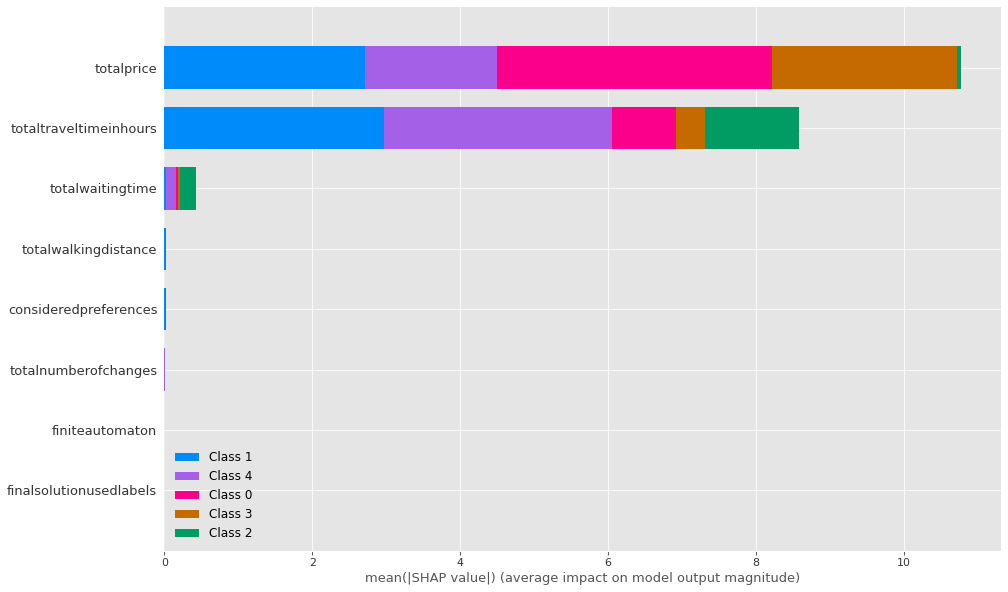

In [148]:
#shap is a game theoretic approach to explain the output of any machine learning model
#Total price was significant in pushing the outcome towards cluster1 (0 with index), traveltime pushed outcomes toward cluster 2 and 5 (1 and 4 with index)
#waiting time contributed in cluster 3 (index2)
shap.summary_plot(shap_values_kk, categ_data, plot_type="bar", plot_size=(15, 10))